# T20 Cricket Data 

This is just a fun little project where instead of baseball data we play with cricket data. The data describe T20 cricket games. We want to see if we can predict how many runs a team is likely to score from any point in the innings. 

## Setup

In [1]:
# Path
from pathlib import Path

# Lets play with numbers
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from   patsy import dmatrices
import scipy.stats as stats

# Show me pretty pictures
import seaborn as sns
import matplotlib.pyplot as plt

# I'm a little picky about colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5) 


### Load data

In [2]:
# Load .csv data as pandas dataframe
data_path = Path("ipl.csv")
if data_path.exists():
    print("Loading data...",end="")
    data = pd.read_csv(data_path)
    print("done.")
else:
    raise SystemExit("Data not found.")

Loading data...done.


Let's check out the data.

In [3]:
data.head(10) 

,runs_scored,overs_remaining,bowling_team,batting_team,date,venue,id,wickets_remaining
0,4,20,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,10
1,15,19,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,10
2,6,18,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,9
3,4,17,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,9
4,9,16,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,9
5,17,15,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,9
6,5,14,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,9
7,11,13,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,9
8,9,12,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,9
9,4,11,Royal Challengers Bangalore,Sunrisers Hyderabad,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1082591,9


Each row correponds to a single *over*. For a full T20 match, we should see 20 rows, or overs. If there are fewer than 20, that means that the batting team had 0 wickets remaining before the 20 overs were reached. 

Let's check out a few things in the data.


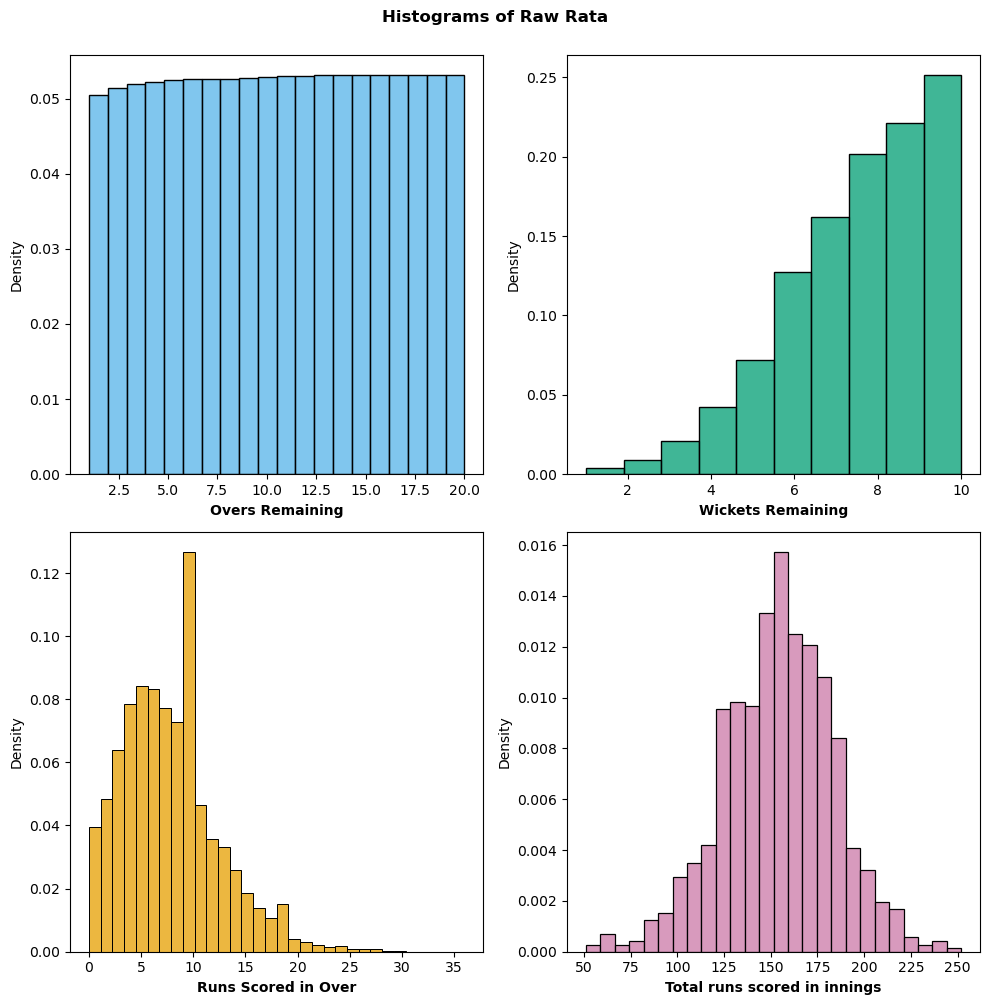

In [4]:
# Make figure
fig, ax = plt.subplots(2,2)#,sharey=True)#sharex=True)
fig.set_size_inches(10,10)
fig.suptitle("Histograms of Raw Rata",fontweight="bold",y=1)

# Distribution of overs
sns.histplot(ax=ax[0,0], data=data,x="overs_remaining",bins=len(data.overs_remaining.unique()),stat="density",color=skyblue)
ax[0,0].set_xlabel("Overs Remaining",fontweight="bold")
# Distribution of wickets remaining
sns.histplot(ax=ax[0,1], data=data,x="wickets_remaining",bins=len(data.wickets_remaining.unique()),stat="density",color=green)
ax[0,1].set_xlabel("Wickets Remaining",fontweight="bold")
# Distribution of runs_scored in each over
sns.histplot(ax=ax[1,0], data=data,x="runs_scored",bins=len(data.runs_scored.unique()),stat="density",color=orange)
ax[1,0].set_xlabel("Runs Scored in Over",fontweight="bold")
# Distribution of final game scores
sns.histplot(ax=ax[1,1], data=data.groupby(by="id").runs_scored.agg("sum"),stat="density",color=pink)
ax[1,1].set_xlabel("Total runs scored in innings",fontweight="bold");
plt.tight_layout()

From looking at these histograms, we see that for the most part, all 20 overs are played in the innings. On the other hand, the number of wickets remaining decreases signficantly, indicating that there are likely many instances where the innings reaches the number of overs before all of the wickets are taken. The runs scored in an over seems to follow something like a Poisson distribution, which would not be unexpected for count data. Finally, the distribution of total runs scored in an innings indicates that, on average, a team expects to score 150-160 total runs.

Let's start by deriving a variable `runs_earned` that is the total runs scored from any combination of `overs_remaining` and `wickets_remaining` and add it to the dataframe. 

In [5]:
# Group by "id" to get unique matches
grouped = data.groupby(by="id")
group_names = [g for g in grouped.groups.keys()]

#  Since we want the runs_scored at the end of the innings from the BEGINNING of the over, we:
#       1.  Compute the (total - cumulative total) to get the runs scored at the end of that over.
#       2.  Shift the data by one row to make 'runs scored' for the beginning of the over. 
#       3.  Fill the nan value created by the shift with the total runs scored since that is the total based on (10 remaining wickets, 20 remaining overs)
data["runs_earned"] = grouped.runs_scored.transform(lambda x: (x.sum() - x.cumsum()).shift(1).fillna(x.sum()))
datacopy = data.copy()

Check for outliers.

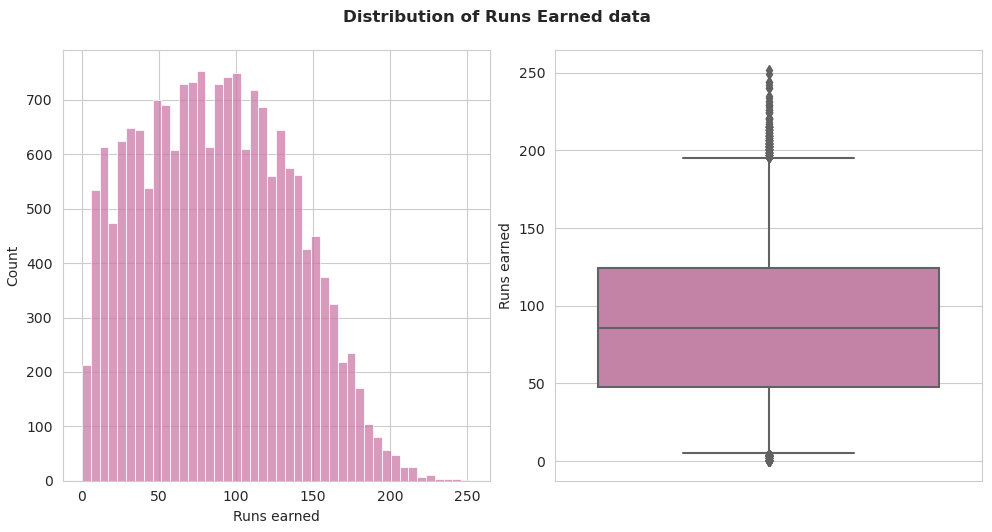

In [6]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    # Show data
    sns.histplot(ax=ax[0],data=data,x="runs_earned",color=pink)
    ax[0].set(xlabel="Runs earned", ylabel="Count", title='')
    sns.boxplot(ax=ax[1],data=data,y="runs_earned",color=pink,whis=[1,99])
    ax[1].set(ylabel="Runs earned",title='')
    plt.tight_layout()
    fig.suptitle("Distribution of Runs Earned data",y=1.05,fontweight="bold")

We can see from the histogram and the boxplot that there are definitely some outliers, particularly on the high side of *runs earned*. The whiskers in this boxplot represent 1.5*IQR by default, but we could change them to specific values, such as the 1st and 99th percentile or some multiple of the standard deviation. For now, it is not clear whether or not these will hurt our models, so let's just leave them for now and consider removing them later. 

If we wanted to trim the data, however, we could do it like this:

In [7]:
# NOTE: We made a copy earlier of the original dataframe before trimming --> datacopy
# data = data.loc[(data.runs_earned > data.runs_earned.quantile(.01)) & (data.runs_earned < data.runs_earned.quantile(.99)),:]

Now lets create a visualization to show how runs earned varies with overs and wickets remaining. The first thing we will do is look at the relationship between runs scored and wickets/overs remaining. For this we are just using the raw data from the table and not using the new variable yet. 

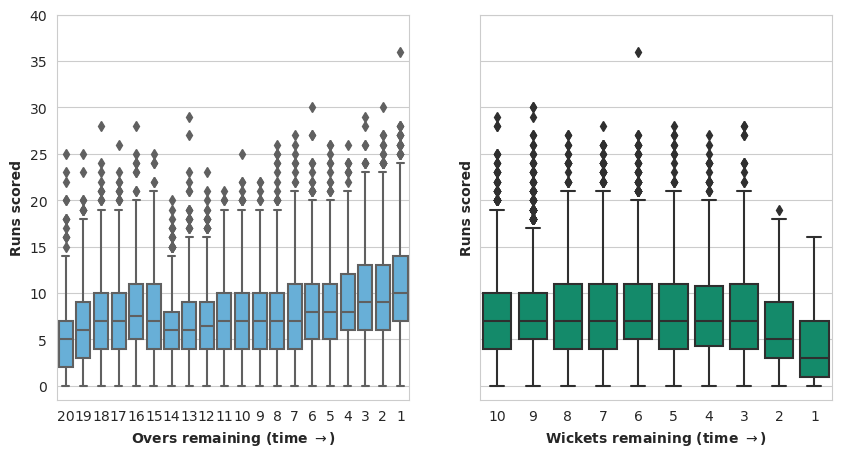

In [8]:
with sns.axes_style("whitegrid"):
    
     # Make figure
    fig, ax = plt.subplots(1,2,sharey=True)#sharex=True)
    fig.set_size_inches(10,5)

    # Runs scored vs overs remaining
    sns.boxplot(ax=ax[0],data=data,y="runs_scored",x="overs_remaining",color=skyblue)
    ax[0].set_xlabel(r"Overs remaining (time $\rightarrow$)",fontweight="bold")
    ax[0].set_ylabel("Runs scored",fontweight="bold")
    ax[0].set_ylim(-1.5,40)
    ax[0].invert_xaxis()

    # Runs scored vs wickets remaining
    sns.boxplot(ax=ax[1],data=data,y="runs_scored",x="wickets_remaining",color=green)
    ax[1].set_xlabel(r"Wickets remaining (time $\rightarrow$)",fontweight="bold")
    ax[1].set_ylabel("Runs scored",fontweight="bold")
    ax[1].invert_xaxis()

A few things stand out to me right away. First, the number of runs scored in the over increases as the innings goes on, i.e., teams are slow to score in the first several overs. As they reach ~6 overs remaining, the average number of runs begins to increase until the end of the innings. This could be a true trend in the data or just an artifact that there are some innings with slightly fewer than 20 overs, meaning the last few bins may have fewer samples. 

On the other hand, the number of wickets remaining does not seem to impact the number of runs scored in the over, except when the innings has 2 or fewer wickets remaining. Of course, from this alone we cannot really see the relationship between overs remaining and wickets remaining. Let's see what the average number of runs scored is for a (wickets_remaining, overs_remaining) combination.

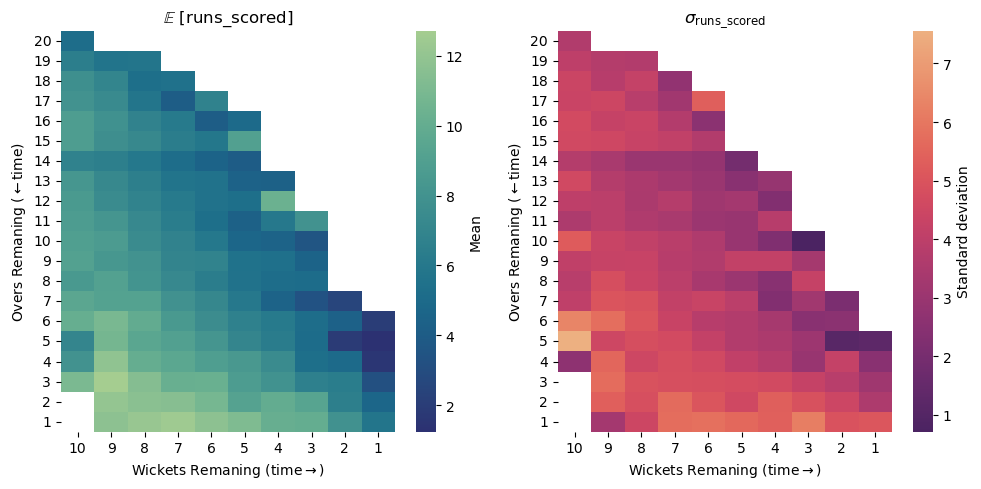

In [9]:
# 1. Group by (wickets_remaining, overs_remaining) combination
# 2. Aggregate data to get the (mean,std) runs_scored for each combination
# 3. Pivot dataframe to make into a 2D array
avg_runs_scored = data.groupby(by=["overs_remaining","wickets_remaining"],as_index=False).agg(
                                                                                             runs_scored_mean=pd.NamedAgg(column="runs_scored",aggfunc="mean"),
                                                                                             runs_scored_std=pd.NamedAgg(column="runs_scored",aggfunc="std")
                                                                                             )

# Format each axis
def format_heatmap(ax,the_title=" "):
    ax.set_xlabel(r"Wickets Remaning (time$\rightarrow$)")
    ax.set_ylabel(r"Overs Remaning ($\leftarrow$time)")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title(the_title)
    return ax

# Make figure
fig, ax = plt.subplots(1,2)#,sharey=True)#sharex=True)
fig.set_size_inches(10,5)

# Make first axis for mean of runs scored
ax[0] = sns.heatmap(ax=ax[0],data=avg_runs_scored.pivot("overs_remaining","wickets_remaining","runs_scored_mean"),
                    cmap="crest_r",cbar_kws={"label":"Mean"})
ax[0] = format_heatmap(ax[0],r"$\mathbb{E}$ [runs_scored]")

# Make first axis for std of runs scored
ax[1] = sns.heatmap(ax=ax[1],data=avg_runs_scored.pivot("overs_remaining","wickets_remaining","runs_scored_std"),
                    cmap="flare_r",cbar_kws={"label":"Standard deviation"})
ax[1] = format_heatmap(ax[1],r"$\sigma_{\mathrm{runs\_scored}}$")

# Clean up
plt.tight_layout()

Interesting. Now we can see which combination of (overs remaining, wickets remaining) results in the highest average number of runs scored (left). We can also see the standard deviation for some of these combinations. This immediately raises some thoughts about some of these bins and whether or not they are outliers. For example, some have extremely high/low mean or standard deviation relative to its neighbors. This could be the true effect or it could be a result of too few sample in that bin. 

Instead of focusing on this, let's go ahead and consider our new variable of interest, *runs earned*. For this we will reuse the figures we just developed. 

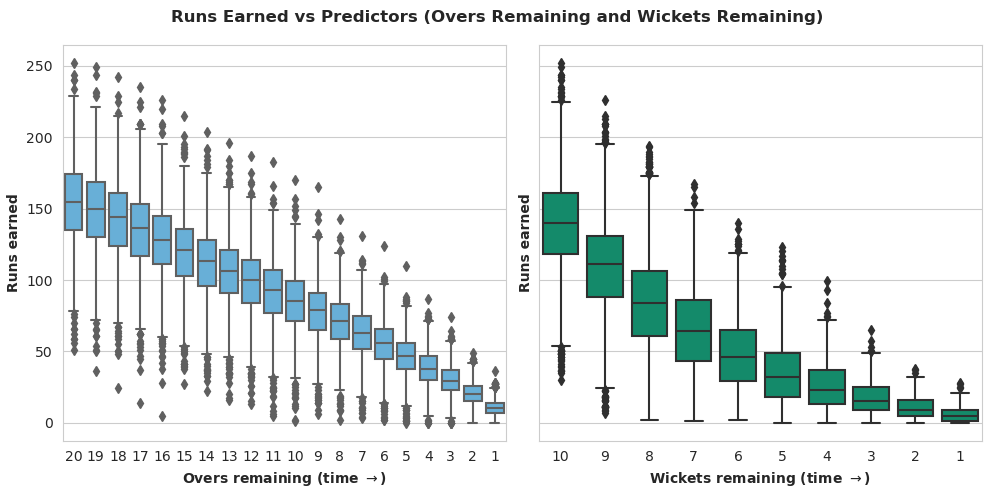

In [10]:
with sns.axes_style("whitegrid"):
    
     # Make figure
    fig, ax = plt.subplots(1,2,sharey=True)#sharex=True)
    fig.set_size_inches(10,5)
    fig.suptitle("Runs Earned vs Predictors (Overs Remaining and Wickets Remaining)",fontweight="bold")
    # Runs scored vs overs remaining
    sns.boxplot(ax=ax[0],data=data,y="runs_earned",x="overs_remaining",color=skyblue)
    ax[0].set_xlabel(r"Overs remaining (time $\rightarrow$)",fontweight="bold")
    ax[0].set_ylabel("Runs earned",fontweight="bold")
    # ax[0].set_ylim(-1.5,40)
    ax[0].invert_xaxis()

    # Runs scored vs wickets remaining
    sns.boxplot(ax=ax[1],data=data,y="runs_earned",x="wickets_remaining",color=green)
    ax[1].set_xlabel(r"Wickets remaining (time $\rightarrow$)",fontweight="bold")
    ax[1].set_ylabel("Runs earned",fontweight="bold")
    ax[1].invert_xaxis()
    plt.tight_layout()


From this figure we can see that the variable `runs_earned` decays nearly linearly with the overs remaining in the innnigs (not actually linear but perhaps close enough for what we want to know). On the other hand, the number runs earned decays exponentially with the wicket remaining in the innings. 

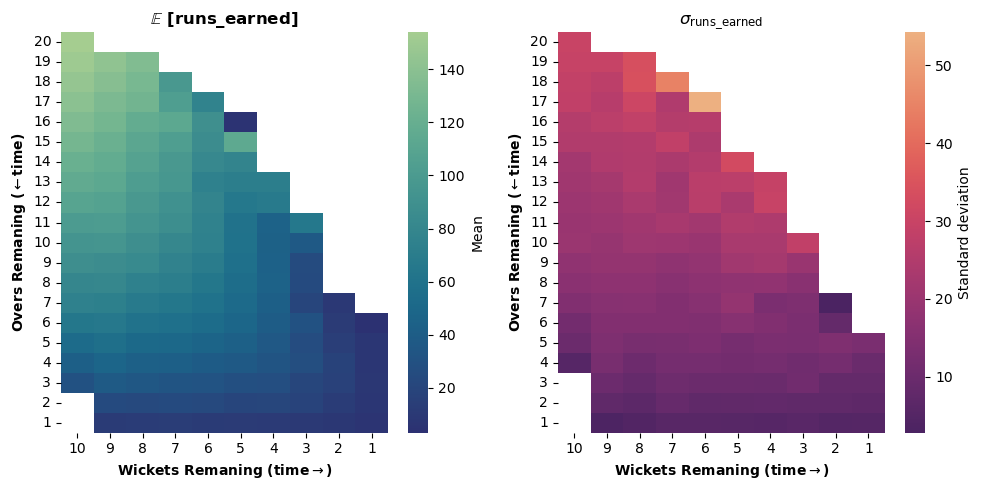

In [11]:
# 1. Group by (wickets_remaining, overs_remaining) combination
# 2. Aggregate data to get the (mean,std) runs_earned for each combination
# 3. Pivot dataframe to make into a 2D array
avg_runs_earned = data.groupby(by=["overs_remaining","wickets_remaining"],as_index=False).agg(
                                                                                             runs_earned_mean=pd.NamedAgg(column="runs_earned",aggfunc="mean"),
                                                                                             runs_earned_std=pd.NamedAgg(column="runs_earned",aggfunc="std")
                                                                                             )

# Format each axis
def format_heatmap(ax,the_title=" "):
    ax.set_xlabel(r"Wickets Remaning (time$\rightarrow$)",fontweight="bold")
    ax.set_ylabel(r"Overs Remaning ($\leftarrow$time)",fontweight="bold")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title(the_title,fontweight="bold")
    return ax

# Make figure
fig, ax = plt.subplots(1,2)#,sharey=True)#sharex=True)
fig.set_size_inches(10,5)

# Make first axis for mean of runs earned
ax[0] = sns.heatmap(ax=ax[0],data=avg_runs_earned.pivot("overs_remaining","wickets_remaining","runs_earned_mean"),
                    cmap="crest_r",cbar_kws={"label":"Mean"})
ax[0] = format_heatmap(ax[0],r"$\mathbb{E}$ [runs_earned]")

# Make first axis for std of runs earned
ax[1] = sns.heatmap(ax=ax[1],data=avg_runs_earned.pivot("overs_remaining","wickets_remaining","runs_earned_std"),
                    cmap="flare_r",cbar_kws={"label":"Standard deviation"})
ax[1] = format_heatmap(ax[1],r"$\sigma_{\mathrm{runs\_earned}}$")

# Clean up
plt.tight_layout()

This shows us a how the average number of earned runs changes as we progress later into the innings through the completion of overs and loss of wickets. This shows us that there are likely to be some clear outliers, such as 16 overs and 5 wickets remaining, where our earned run expectancy table is indicating that the average number or runs earned from that game position is below 20 with a standard deviation of over 50 runs. This is clearly inconsistent with similar game positions, such as 15 or 16 overs with 6 wickets remaining. It is unlikely that the loss or a single wicket results in a reduction in expected runs of nearly 100! This is something we can definitely address. 

Out goal in the next section is to build a model to estimate the average expected runs from any combination of wickets and overs remaining. What we really want to know is how informative each of those squares in the above figure is for predicting runs earned. This might be a little messy, but lets expand each of those to look at the distribution for any given combination of overs/wickets remaining. 

Text(1, -2, 'Widgets Remaining')

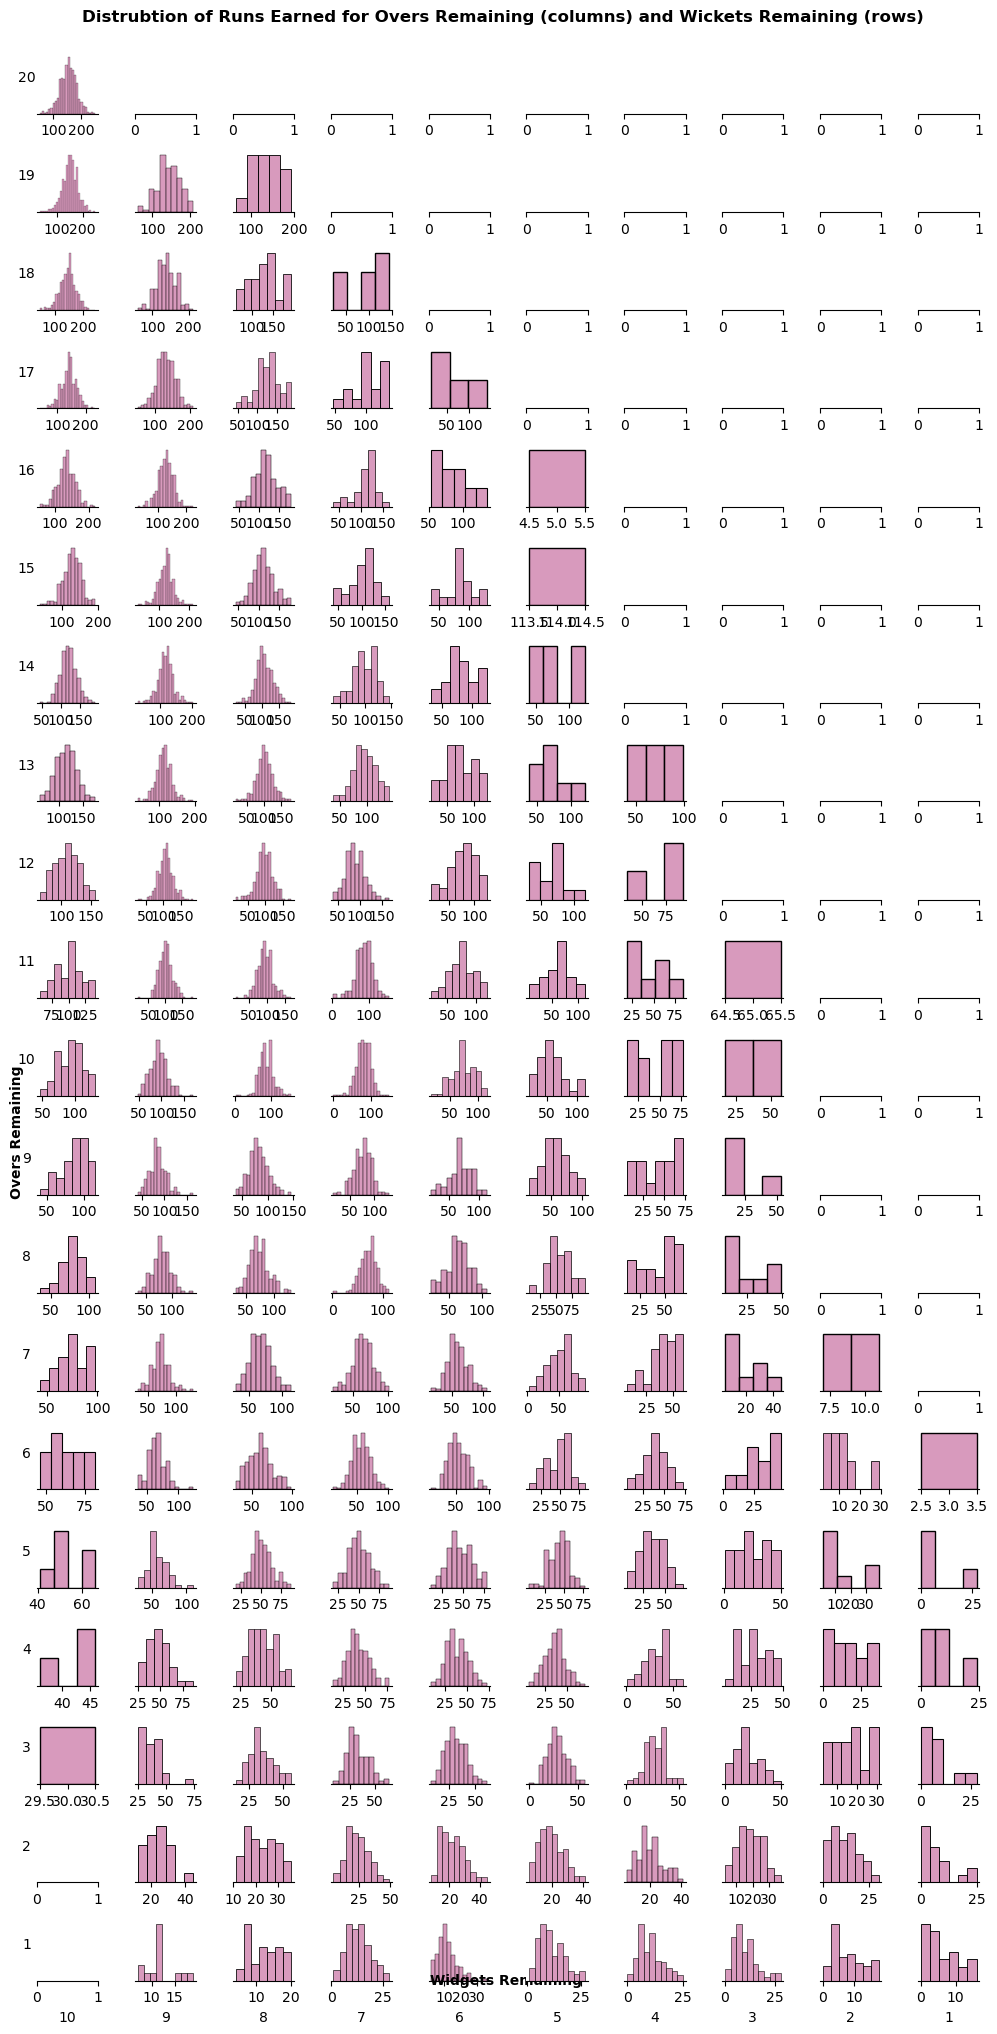

In [12]:
# NOTE: This is a very crude way to make this figure but it works. It can be done with sns.FacetGrid 
# or other ways w/o the nested loops, but this is the most straight forward day to get it done. Not pretty but it works. 

# Make figure
fig, ax = plt.subplots(20,10)
fig.set_size_inches(10,20)
fig.set_facecolor("w")
grouped = data.groupby(by=["overs_remaining","wickets_remaining"])
group_names = [g for g in grouped.groups.keys()]

# For each remaining over
for ii in np.flipud(np.arange(1,21)):
    aa = 20-ii
    # For each remaining wicket
    for jj in np.flipud(np.arange(1,11)):
        bb = 10-jj
        # If in data the show histogram
        if (ii,jj) in group_names:
            sns.histplot(ax=ax[aa,bb],data=grouped.get_group((ii,jj)),x="runs_earned",color=pink)
        # Clean up
        # ax[aa,bb].set_xlim(0,200)
        # ax[aa,bb].set_xticks([])
        ax[aa,bb].set_yticks([])
        ax[aa,bb].set_ylabel("")
        ax[aa,bb].set_xlabel("")
        ax[aa,bb].spines['right'].set_visible(False)
        ax[aa,bb].spines['top'].set_visible(False)
        ax[aa,bb].spines['left'].set_visible(False)
        # Add xlabel to bottom
        if ii == 1:
                ax[aa,bb].set_xlabel(str(jj))
    # Add y label only to left side
    ax[aa,0].set_ylabel(str(ii),rotation=0)
    plt.tight_layout()
# Set title
fig.suptitle("Distrubtion of Runs Earned for Overs Remaining (columns) and Wickets Remaining (rows)",fontweight="bold",y=1.015)
ax[11,0].text(-.65,0,"Overs Remaining",rotation=90,fontweight="bold")
ax[19,4].text(1,-2,"Widgets Remaining",rotation=0,fontweight="bold")

If we want to see a particular game state, we can just change the numbers below. It would be nice to add a widget here to make this easy with a dropdown.

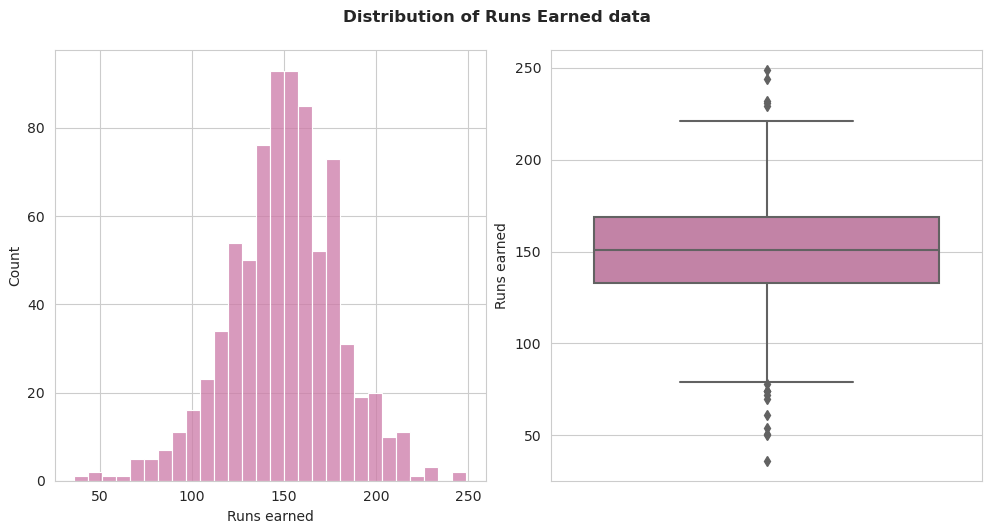

In [13]:
wickets_remaining, overs_remaining = 10, 19
with sns.axes_style("whitegrid"):    
    # Make figure
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    # Show data
    thisdata = data.loc[(data.wickets_remaining==wickets_remaining) & (data.overs_remaining==overs_remaining),:].copy()
    sns.histplot(ax=ax[0],data=thisdata,x="runs_earned",color=pink)
    ax[0].set(xlabel="Runs earned", ylabel="Count", title='')
    sns.boxplot(ax=ax[1],data=thisdata,y="runs_earned",color=pink)#,whis=[1,99])
    ax[1].set(ylabel="Runs earned",title='')
    plt.tight_layout()
    fig.suptitle("Distribution of Runs Earned data",y=1.05,fontweight="bold")

Next, lets build a model to estimate the average expected runs that can be earned from any possible combination of overs and wickets remaining.

### Look-up table
We can start with the most basic way of doing this. Consider the table,`avg_runs_earned`, that is generated from aggregating across `overs_remaining` and `wickets_remaining`. We can simply treat this as a look-up table and make estimates directly from this.

In [14]:
expected_runs = avg_runs_earned.pivot("overs_remaining","wickets_remaining","runs_earned_mean")
expected_runs

wickets_remaining,1,2,3,4,5,6,7,8,9,10
overs_remaining,,,,,,,,,,
1,5.740741,7.898305,9.983333,10.129630,11.188571,11.691860,12.472727,12.162162,11.714286,NaN
2,7.578947,11.971429,18.217949,20.111111,19.698925,22.528037,23.641791,23.114754,23.650000,NaN
3,8.181818,16.555556,20.560000,27.672897,28.304348,31.706667,32.430168,34.295918,37.392857,30.000000
4,7.400000,17.666667,27.060606,32.135135,36.557692,38.821577,42.085000,43.088235,47.238095,42.000000
5,7.250000,14.125000,25.807692,35.508772,43.079365,46.504386,50.400000,50.919075,57.032258,52.666667
6,3.000000,10.750000,29.636364,39.183673,47.835052,53.880597,57.254167,59.630332,66.096386,63.909091
7,NaN,9.000000,19.750000,41.382353,51.743902,59.385542,64.174419,67.866071,73.000000,74.470588
8,NaN,NaN,24.125000,44.280000,54.851852,64.012346,71.643777,74.019763,80.601351,79.633333
9,NaN,NaN,24.750000,43.833333,57.714286,69.088889,75.981818,82.898833,85.743719,87.750000


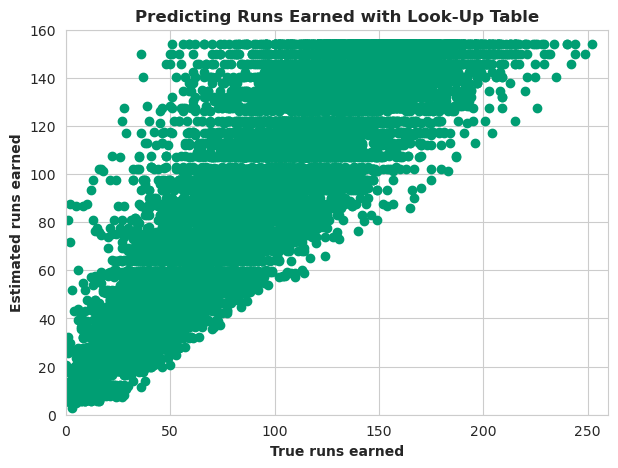

In [15]:
def lookup_expected_earned_runs(row,table):
    # Get row of look up table
    mask = (table.overs_remaining==row.overs_remaining) & (table.wickets_remaining==row.wickets_remaining)
    # Get data
    row["runs_earned_estimate"] = table.loc[mask ,"runs_earned_mean"].item()
    return row
    
temp = data.apply(lambda row: lookup_expected_earned_runs(row,avg_runs_earned),axis=1)

with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    ax.scatter(temp.runs_earned,temp.runs_earned_estimate,color=green)
    ax.set_xlabel("True runs earned",fontweight="bold")
    ax.set_ylabel("Estimated runs earned",fontweight="bold")
    ax.set_title("Predicting Runs Earned with Look-Up Table",fontweight="bold")
    ax.set_xlim(0,260)
    ax.set_ylim(0,160)

Well the reults do not look great. We could see going into this that using the table was going to have issues. Disregarding the outliers for a momement, we can see that many of the instances in the table have `nan` values. In our case, we are using the table made directly from the data, but this could be an issue in the future when we encounter a new game situation. We need a model that is far more robust. Just to show an example, let's consider the case of 14 overs and 4 wickets remaining. 

In [16]:
# Get row of look up table
mask = (avg_runs_earned.overs_remaining==14) & (avg_runs_earned.wickets_remaining==4)
# Get data
avg_runs_earned.loc[mask ,"runs_earned_mean"]

Series([], Name: runs_earned_mean, dtype: float64)

This was an obvious result, but it is worth seeing. While that combination might be uncommon (and even nonexistent in our data), it does not mean that it is not possible, especially since the adjacent values have instances that occured. 

### Ordinary Least Square (OLS) regression
In almost all cases, a simple linear model is the best initial approach, so that is what we will do here. Let start by removing any of the (overs remaining, wickets remaining) combinations that have few samples.

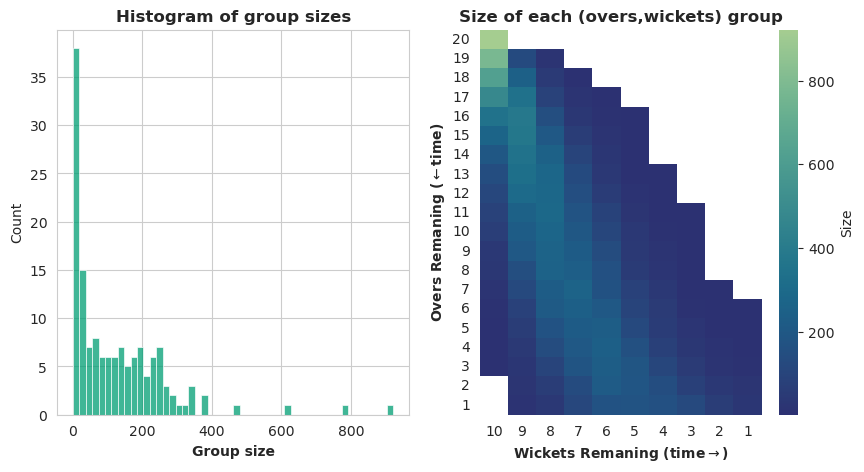

In [17]:
with sns.axes_style("whitegrid"):
    
    # Make figure
    fig, ax = plt.subplots(1,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(10,5)
    
    # Get size of each group
    groupsizes = data.groupby(by=["overs_remaining","wickets_remaining"],as_index=False).agg(runs_earned_size=pd.NamedAgg(column="runs_earned",aggfunc="size"))

    # Histogram of group sizes
    sns.histplot(ax=ax[0],data=groupsizes.runs_earned_size,color=green,bins=50)
    ax[0].set_xlabel("Group size",fontweight="bold")
    ax[0].set_title("Histogram of group sizes",fontweight="bold")
        
    # Heatmap
    ax[1] = sns.heatmap(ax=ax[1],data=groupsizes.pivot("overs_remaining","wickets_remaining","runs_earned_size"),
                        cmap="crest_r",cbar_kws={"label":"Size"})
    ax[1] = format_heatmap(ax[1],"Size of each (overs,wickets) group")


We see that the first few values at the start of the innings have the most values--(20,10) is where everyone the innings starts--but that the size reduces signficantly for the remainder of the groups. The path along the diagonal is more occupied than the edges. First we are going to divide the data into a training and test set and then will arbitrarily remove groups with fewer than 20 instances per group from the training group. We will not do this to the test set since we want to see how well our model predicts in all cases.

In [18]:

# Lets first hold out a few matches so we can test our method. 
test_id = data.id.sample(10)
data["test_data"] = 0
data.loc[np.where(data.id.isin(test_id))[0],"test_data"] = 1

# Get train/test data
train = data.loc[~data.id.isin(test_id), :]
test  = data.loc[data.id.isin(test_id),:]

# Which data to remove
to_remove = list(zip(groupsizes.loc[groupsizes.runs_earned_size < 20,"overs_remaining"],groupsizes.loc[groupsizes.runs_earned_size < 20,"wickets_remaining"]))
train.loc[:,"overs_wicket_tuple"] = train.loc[:,["overs_remaining","wickets_remaining"]].apply(tuple,axis=1)
train = train.loc[~train.overs_wicket_tuple.isin(to_remove),:]

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_79779/2613672518.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,"overs_wicket_tuple"] = train.loc[:,["overs_remaining","wickets_remaining"]].apply(tuple,axis=1)


Now we will fit a model. Here we assume that the runs earned is a linear combination of the overs remaining and wickets remaining.  We also make no assumptions about the distributions or type of the data. Mathematically, we model our data as:

\begin{align*}
Y & = X\beta + \epsilon.
\end{align*}

Given that we are using two predictors, *overs_remaining* and *wickets_remaining*, we can write out the model explicitly as

\begin{align*}
y_i & = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \epsilon,
\end{align*}

where 

\begin{align*}
y_i & = \text{runs earned for sample} ~i,\\
x_{i1} & = \text{overs remaining for sample}~ i,\\
x_{i2} & = \text{wickets remaining for sample}~ i,\\
\beta_{1,2} & = \text{model coefficients for~} x_{i1}, x_{i2}, \text{respectively, and}\\
\beta_0 & = \text{intercept}.
\end{align*}

In our analysis using `statsmodels`, we can conveneniently use `R` style syntax to represent our model: 
\begin{align*}
{\text{runs\_earned $\sim$ overs\_remaining + wickets\_remaining}}
\end{align*}


In [19]:
# Using statsmodels and R style formulas
fml = 'runs_earned ~ overs_remaining + wickets_remaining'

# Design matrices
cols = ["runs_earned","overs_remaining","wickets_remaining"]
y_train, X_train = dmatrices(fml, train[cols], return_type='dataframe')

# Implement model
ols_model = sm.OLS(y_train, X_train).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            runs_earned   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                 3.628e+04
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:15:28   Log-Likelihood:                -79514.
No. Observations:               17751   AIC:                         1.590e+05
Df Residuals:                   17748   BIC:                         1.591e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -16.0203      0.775    -20.682      0.000     -17.539     -14.502
overs_remaining       6.1737      0.045    138.257      0.000       6.086       6.261
wickets_remaining     4.9324      0.137     36.090      0.000       4.665       5.200
==============================================================================
Omnibus:                      776.670   Durbin-Watson:                   0.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2429.283
Skew:                          -0.130   Prob(JB):                         0.00
Kurtosis:                       4.794   Cond. No.                         70.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now lets see what the in-sample prediction looks like.

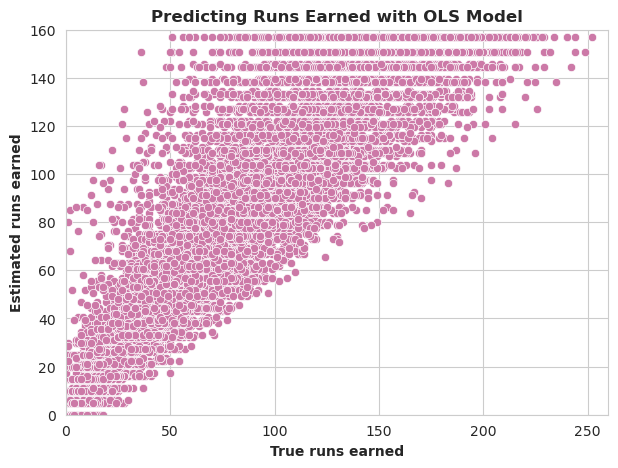

In [20]:
with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.scatterplot(x=y_train.values.ravel(),y=ols_model.predict(X_train).values,color=pink)
    ax.set_xlabel("True runs earned",fontweight="bold")
    ax.set_ylabel("Estimated runs earned",fontweight="bold")
    ax.set_title("Predicting Runs Earned with OLS Model",fontweight="bold")
    ax.set_xlim(0,260)
    ax.set_ylim(0,160)

Well, this honestly does not look much better than our initial model of just sampling from the table. It seems that our estimates are overly inflated for inning with low total runs scored. In reality, we are not doing anything signficantly different from the look up table, except that we have a model that provides a prediction for any value of (overs_remaining, wickets_remaining). For example, using the look-up table we were unable to ask about some situations. 

In [21]:
# Predict unseen situation from OLS model
print("The estimated runs earned for a (14,4) situation (unseen in data) is: {:.2f} additional runs earned/innings".format(ols_model.predict(pd.DataFrame({"Intercept": [1], "overs_remaining":[14], "wickets_remaining":[4]})).item()))


The estimated runs earned for a (14,4) situation (unseen in data) is: 90.14 additional runs earned/innings


Now let's see how well this model predicts out of sample data. For this we resevered several matches with a complete innings to see how well the model forecasts for each game state. Note that in the model we are not assuming any time relationship, but we are nonetheless using this to predict the end state (total runs earned) given the current game state (runs/wickets remaining).

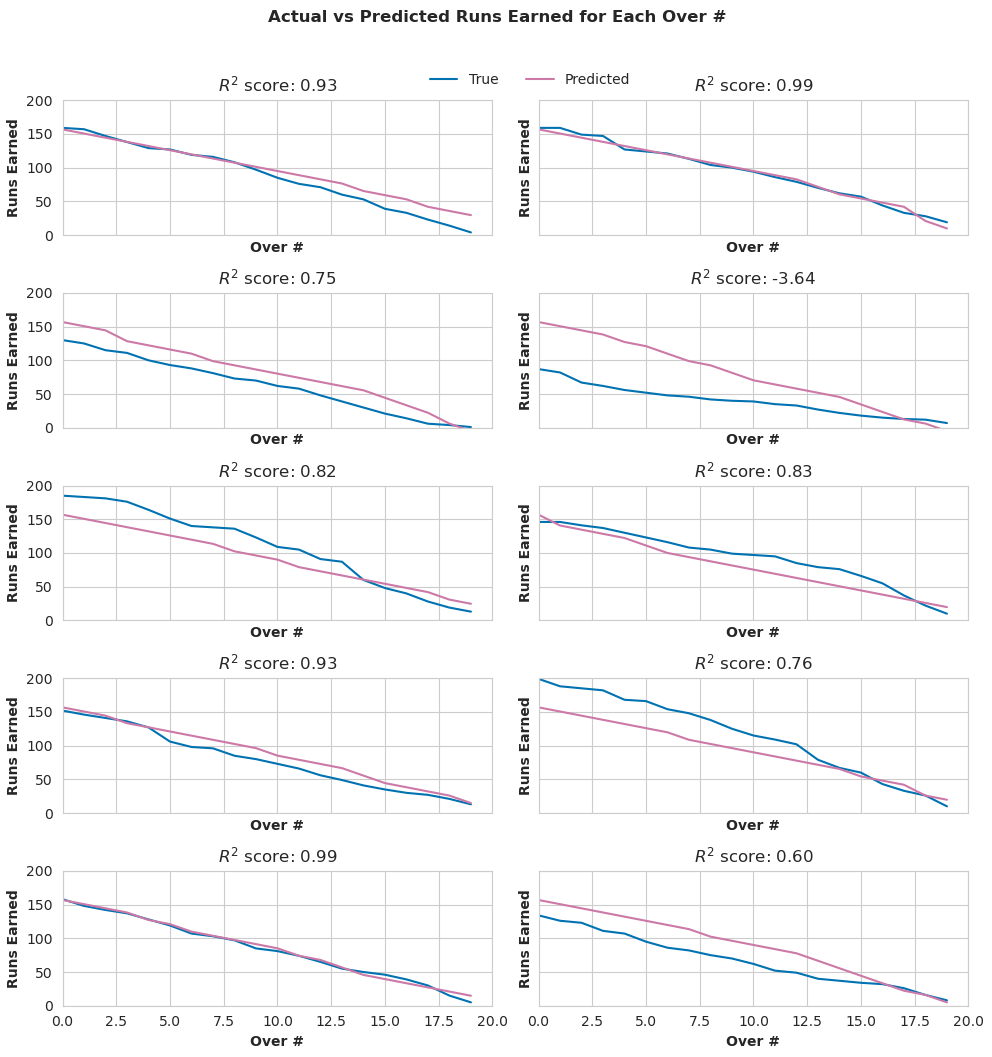

In [22]:
from sklearn.metrics import r2_score

with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(5,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    fig.set_facecolor("w")

    for (id,ax) in zip(test_id,allax.flatten()):
        y_test , X_test  = dmatrices(fml, test.loc[test.id==id,:],  return_type='dataframe')
        ax.plot(y_test.values.ravel(),color=blue_cb,label="True")
        ax.plot(ols_model.predict(X_test).values,color=pink,label="Predicted")
        ax.set_ylabel("Runs Earned",fontweight="bold")
        ax.set_xlabel("Over #",fontweight="bold")
        ax.set_xlim(0,20)
        ax.set_ylim(0,200)
        ax.set_title(r"$R^2$ score: " + "{:.2f}".format(r2_score(y_test.values.ravel(),ols_model.predict(X_test).values)))

    plt.tight_layout()
    allax[0,0].legend(loc="right",bbox_to_anchor=(1.35,1.15),ncol=2,frameon=False)
    fig.suptitle("Actual vs Predicted Runs Earned for Each Over #",fontweight="bold",y=1.05)
    

This is pretty interesting. Despite our model inconsistencies, we still achieve $R^2$ values of over 0.9 for several of the hold out innings.

### Poisson Regression

One of the issues with our previous model is that we are not accounting for the datatype of the dependent variable, *runs earned*, in our model. In this case, we are dealing with a form of *count* data. For this, we will implement a generalized linear model (GLM) where we assume the response data are Poisson distributed. The regression model takes the form

\begin{align*}
\log(\lambda_i) & = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2},
\end{align*}

where $\lambda_i$ is the Poisson parameter. We can think of an analagous problem to help us understand why this is a useful way of thinking about the problem. Lets consider a bridge, say the Ben Franklin Bridge that connects Philadelphia, PA to New Jersey. We want to know how many people pass through the bridge given the day of the week (M,T,W,...) and month of the year (Jan, Feb,...). So, given a new day and month, how many people do we expect to see? We have the same problem: given a number of overs/wickets remaining, how many runs should we expect to earn? Just like before, we can do this in `statsmodels`, this time using a GLM with with a Poisson distribution. 

In [23]:
# We already have our patsy design matrices from above where we provided the formula directly.
# fml = 'runs_earned ~ overs_remaining + wickets_remaining'
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            runs_earned   No. Observations:                17751
Model:                            GLM   Df Residuals:                    17748
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1535e+05
Date:                Wed, 05 Oct 2022   Deviance:                   1.2262e+05
Time:                        11:15:29   Pearson chi2:                 1.15e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.8925      0.005    575.207      0.000       2.883       2.902
overs_remaining       0.0666      0.000    273.204      0.000       0.066       0.067
wickets_remaining     0.0950      0.001    115.302      0.000       0.093       0.097
=====================================================================================
"""

In looking at the summary table, one thing should stand out right away. The deviance and Pearson $\chi^2$ are very large, indicating that we are highly unlikely to get a good fit from this model. We can look up the value in a $\chi^2$ for the signficance level (e.g., $p = 0.05$) with the degrees of freedom, and we find that the value us much smaller and the reported value in the summary table above.

In [24]:
from scipy.stats import chi2
print("Required: {:.1f}\nObserved: {:.1f}".format(poisson_model.deviance,chi2.ppf((1-0.05),poisson_model.df_resid)))

Required: 122617.0
Observed: 18059.0


In addition to this, we already know we violated an assumption of this model from the beginning.

In [25]:
print("Mean: {:.2f} | Variance {:.2f}".format(y_train.mean().item(), y_train.var().item()))

Mean: 87.92 | Variance 2316.70


For a Poisson model, the mean and variance should be equal for it to be a valid assumption. Clearly that is not the case here. Nevertheless, let's check the same figures as the OLS model.

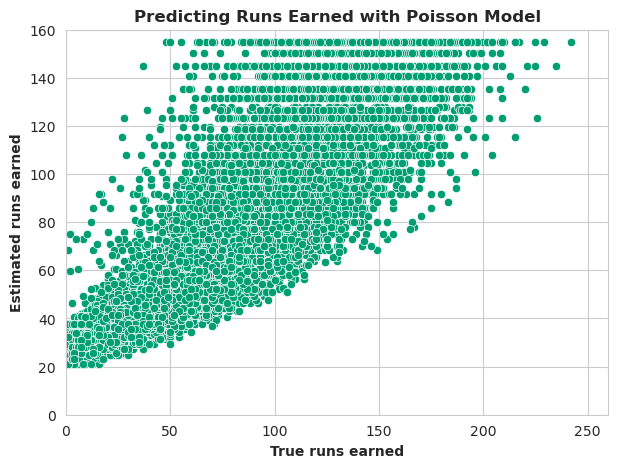

In [26]:
with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.scatterplot(x=y_train.values.ravel(),y=poisson_model.predict(X_train).values,color=green)
    ax.set_xlabel("True runs earned",fontweight="bold")
    ax.set_ylabel("Estimated runs earned",fontweight="bold")
    ax.set_title("Predicting Runs Earned with Poisson Model",fontweight="bold")
    ax.set_xlim(0,260)
    ax.set_ylim(0,160)

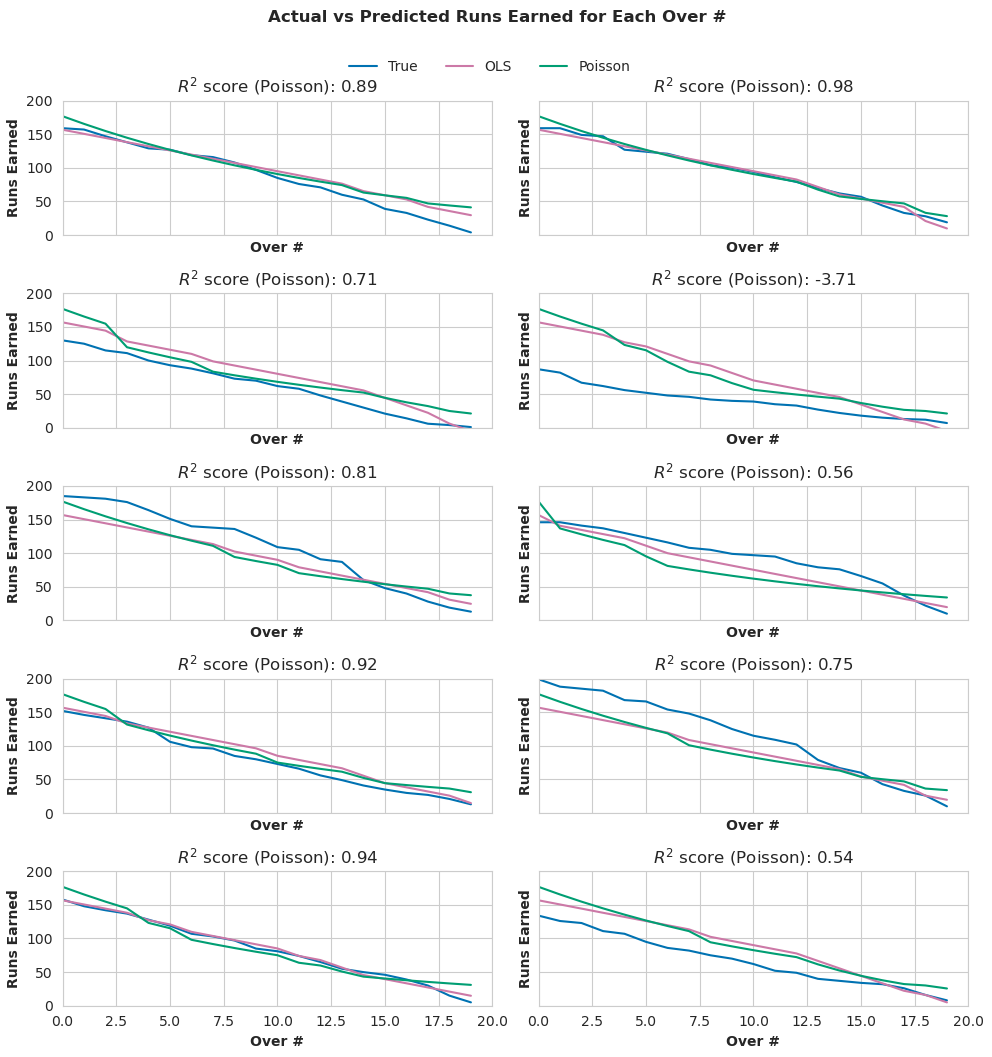

In [27]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(5,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    fig.set_facecolor("w")

    for (id,ax) in zip(test_id,allax.flatten()):
        y_test , X_test  = dmatrices(fml, test.loc[test.id==id,:],  return_type='dataframe')
        ax.plot(y_test.values.ravel(),color=blue_cb,label="True")
        ax.plot(ols_model.predict(X_test).values,color=pink,label="OLS")
        ax.plot(poisson_model.predict(X_test).values,color=green,label="Poisson")
        ax.set_ylabel("Runs Earned",fontweight="bold")
        ax.set_xlabel("Over #",fontweight="bold")
        ax.set_xlim(0,20)
        ax.set_ylim(0,200)
        ax.set_title(r"$R^2$ score (Poisson): " + "{:.2f}".format(r2_score(y_test.values.ravel(),poisson_model.predict(X_test).values)))

    plt.tight_layout()
    allax[0,0].legend(loc="right",bbox_to_anchor=(1.35,1.25),ncol=3,frameon=False)
    fig.suptitle("Actual vs Predicted Runs Earned for Each Over #",fontweight="bold",y=1.05)
    

In [28]:
nb_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial()).fit()
nb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            runs_earned   No. Observations:                17751
Model:                            GLM   Df Residuals:                    17748
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94557.
Date:                Wed, 05 Oct 2022   Deviance:                       2402.9
Time:                        11:15:31   Pearson chi2:                 1.88e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2669
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.6511      0.037     72.058      0.000       2.579       2.723
overs_remaining       0.0790      0.002     37.442      0.000       0.075       0.083
wickets_remaining     0.1063      0.006     16.412      0.000       0.094       0.119
=====================================================================================
"""

### Negative Binomial Regression

Unfortunately, our dependent variable is overdispersed, meaning our Poisson model is incorrrect for our application. Instead we will chose to use negative binomial distribution, which still works for our count data, but does not make the mean = variance assumption. 

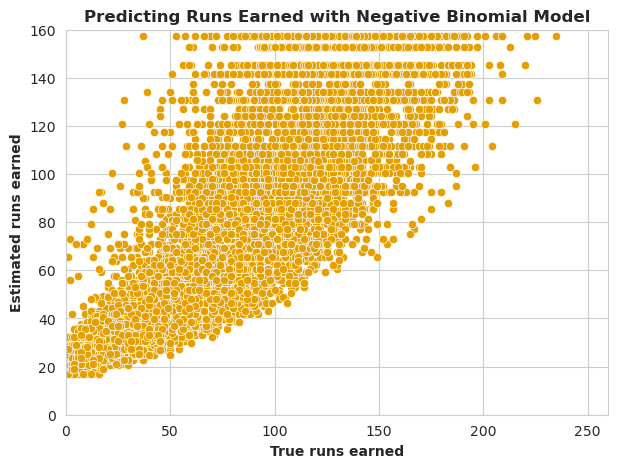

In [29]:
with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.scatterplot(x=y_train.values.ravel(),y=nb_model.predict(X_train).values,color=orange)
    ax.set_xlabel("True runs earned",fontweight="bold")
    ax.set_ylabel("Estimated runs earned",fontweight="bold")
    ax.set_title("Predicting Runs Earned with Negative Binomial Model",fontweight="bold")
    ax.set_xlim(0,260)
    ax.set_ylim(0,160)


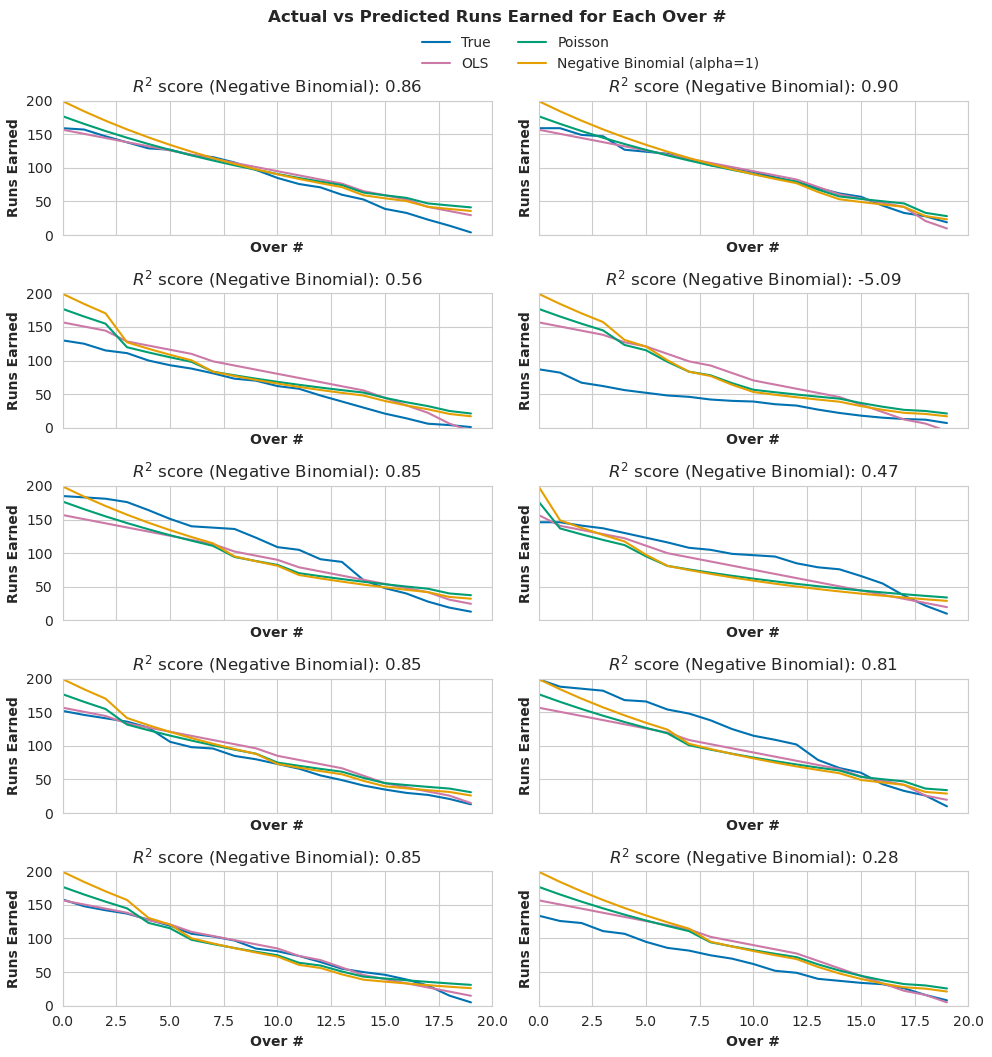

In [30]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(5,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    fig.set_facecolor("w")

    for (id,ax) in zip(test_id,allax.flatten()):
        y_test , X_test  = dmatrices(fml, test.loc[test.id==id,:],  return_type='dataframe')
        ax.plot(y_test.values.ravel(),color=blue_cb,label="True")
        ax.plot(ols_model.predict(X_test).values,color=pink,label="OLS")
        ax.plot(poisson_model.predict(X_test).values,color=green,label="Poisson")
        ax.plot(nb_model.predict(X_test).values,color=orange,label="Negative Binomial (alpha=1)")
        ax.set_ylabel("Runs Earned",fontweight="bold")
        ax.set_xlabel("Over #",fontweight="bold")
        ax.set_xlim(0,20)
        ax.set_ylim(0,200)
        ax.set_title(r"$R^2$ score (Negative Binomial): " + "{:.2f}".format(r2_score(y_test.values.ravel(),nb_model.predict(X_test).values)))

    plt.tight_layout()
    allax[0,0].legend(loc="right",bbox_to_anchor=(1.65,1.35),ncol=2,frameon=False)
    fig.suptitle("Actual vs Predicted Runs Earned for Each Over #",fontweight="bold",y=1.05)
    


The predicted vs actual runs earned plot shows the same pattern as the Poisson model, while the innings time series shows that the Negative Binomial model has the worst overall peformance. This is interesing since it makes more clear assumptions about the data. One of the problems might be that the variance is modeled as 
\begin{align*}
variance = \mu + \alpha\mu^2,
\end{align*}

where $\mu$ is the mean and $\alpha$ is one scaling parameters. The model above is based on a default value of $\alpha = 1$. Let's try and find the correct value of $\alpha$ by following an approach [outlined here](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/).

#### Fitting $\alpha$ for a better Negative Binomial model

In [31]:
# Add lambdas for each row to the training dataframe
train["lambda_val"]      = poisson_model.mu
train["aux_ols_dep"] = train.apply(lambda x: ((x["runs_earned"] - x["lambda_val"])**2 - x["lambda_val"]) / x["lambda_val"],axis=1)
alpha_ols_fml = "aux_ols_dep ~ lambda_val - 1"
aux_ols_model = smf.ols(alpha_ols_fml,train).fit()

print("alpha = {:.3f}, p = {}".format(aux_ols_model.params.item(), 2*stats.t.sf(aux_ols_model.tvalues.item(),aux_ols_model.df_resid)))

alpha = 0.049, p = 0.0


This means that our computed $\alpha$ value is 0.05 at a very high significance level, meaning our assumption of $\alpha = 1$ was wrong.

In [32]:
alpha_val = aux_ols_model.params.item()
nb_model2 = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha_val)).fit()
nb_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            runs_earned   No. Observations:                17751
Model:                            GLM   Df Residuals:                    17748
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -83364.
Date:                Wed, 05 Oct 2022   Deviance:                       30995.
Time:                        11:15:33   Pearson chi2:                 2.70e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9922
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.7298      0.010    277.499      0.000       2.710       2.749
overs_remaining       0.0758      0.001    141.549      0.000       0.075       0.077
wickets_remaining     0.1015      0.002     59.999      0.000       0.098       0.105
=====================================================================================
"""

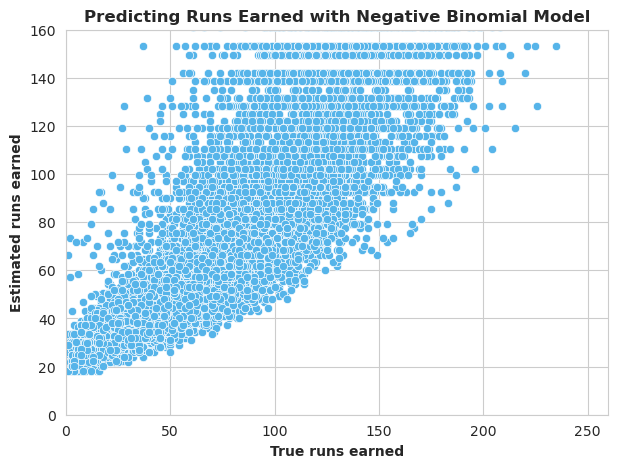

In [60]:
with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.scatterplot(x=y_train.values.ravel(),y=nb_model2.predict(X_train).values,color=skyblue)
    ax.set_xlabel("True runs earned",fontweight="bold")
    ax.set_ylabel("Estimated runs earned",fontweight="bold")
    ax.set_title("Predicting Runs Earned with Negative Binomial Model",fontweight="bold")
    ax.set_xlim(0,260)
    ax.set_ylim(0,160)


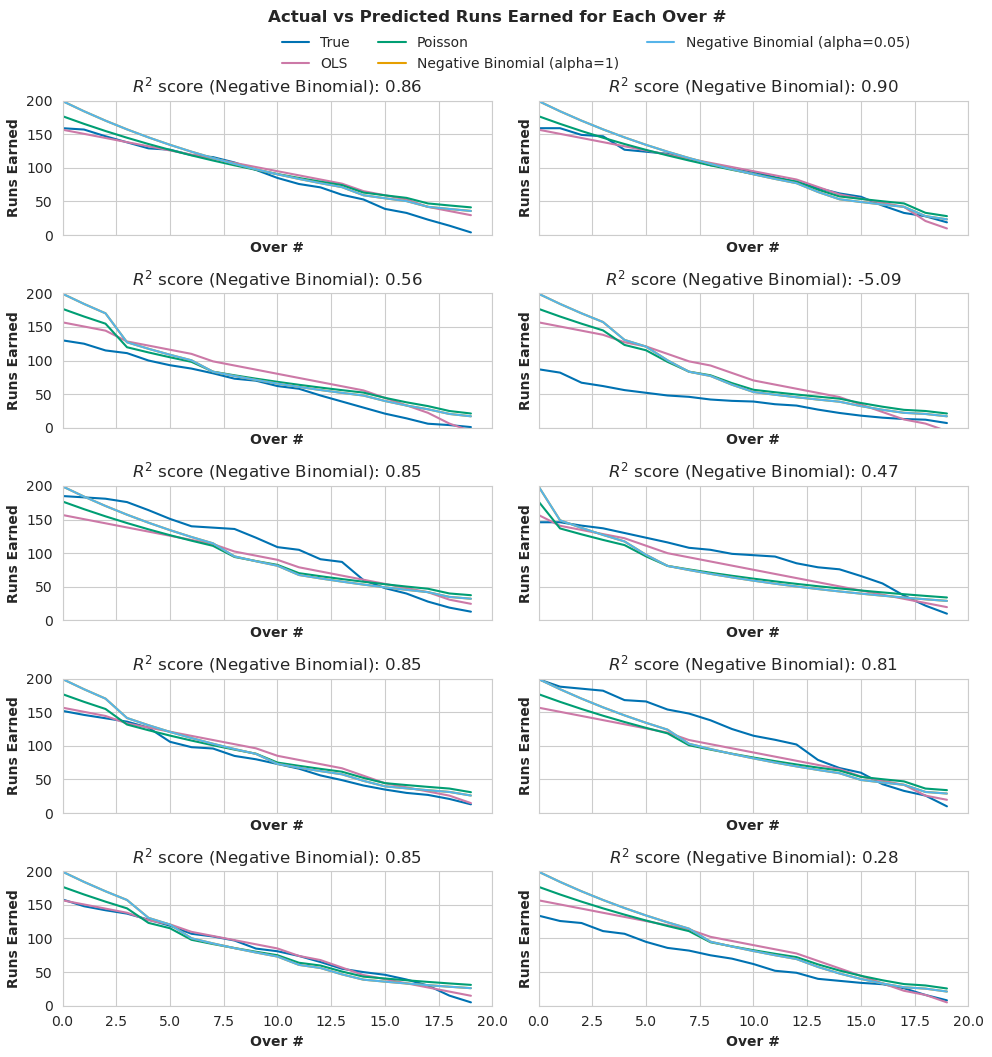

In [61]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(5,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    fig.set_facecolor("w")

    for (id,ax) in zip(test_id,allax.flatten()):
        y_test , X_test  = dmatrices(fml, test.loc[test.id==id,:],  return_type='dataframe')
        ax.plot(y_test.values.ravel(),color=blue_cb,label="True")
        ax.plot(ols_model.predict(X_test).values,color=pink,label="OLS")
        ax.plot(poisson_model.predict(X_test).values,color=green,label="Poisson")
        ax.plot(nb_model.predict(X_test).values,color=orange,label="Negative Binomial (alpha=1)")
        ax.plot(nb_model.predict(X_test).values,color=skyblue,label="Negative Binomial (alpha={:.2f})".format(aux_ols_model.params.item()))
        ax.set_ylabel("Runs Earned",fontweight="bold")
        ax.set_xlabel("Over #",fontweight="bold")
        ax.set_xlim(0,20)
        ax.set_ylim(0,200)
        ax.set_title(r"$R^2$ score (Negative Binomial): " + "{:.2f}".format(r2_score(y_test.values.ravel(),nb_model.predict(X_test).values)))

    plt.tight_layout()
    allax[0,0].legend(loc="right",bbox_to_anchor=(2,1.35),ncol=3,frameon=False)
    fig.suptitle("Actual vs Predicted Runs Earned for Each Over #",fontweight="bold",y=1.05)
    


Well, sadly that did not appear to improve our model from the previous model where we assume $\alpha=1$. 

#### Model comparison

Is we simply compare the log-likelihood of each of the four models, we find that OLS maximizes the log-likelihood with the Negative-Binomial with custom $\alpha$ value coming in second. 

In [62]:
pd.DataFrame({"Model": ["OLS","Poisson","Negative Binomial (alpha=1)","Negative Binomial (alpha=0.05)"], "Log-likelihood":[ols_model.llf,poisson_model.llf,nb_model.llf,nb_model2.llf]}).set_index("Model").sort_values(by="Log-likelihood",ascending=False)

,Log-likelihood
Model,
OLS,-79514.303517
Negative Binomial (alpha=0.05),-83363.745398
Negative Binomial (alpha=1),-94556.536198
Poisson,-115354.039160


The OLS model performs better but the Negative Binomial may make better assumptions about the data. However, in some cases, when the actual earned runs is much lower than average, the Poisson and Negative Binomial peform much better than OLS.

Although interesting, these models only tells us about the potential earned runs given a state, but they does not really allow us to interrogate how to approach the game. For example, should we bat aggressively and risk losing wickets, or should we remain conservative and let the overs progress while working harder to retain wickets.

### Add predictors as categorical

Since we will be one-hot encoding, it is possible that some of the training sets will not have the categories present in the full training set. The first thing we need to do is use the original train/test split, but create new dmatrices with all data and then split manually. 


In [131]:
train = data.loc[data.test_data==0, :]
test  = data.loc[data.test_data==1, :]

# Which data to remove
to_remove = list(zip(groupsizes.loc[groupsizes.runs_earned_size < 20,"overs_remaining"],groupsizes.loc[groupsizes.runs_earned_size < 20,"wickets_remaining"]))
train.loc[:,"overs_wicket_tuple"] = train.loc[:,["overs_remaining","wickets_remaining"]].apply(tuple,axis=1)
test.loc[:,"overs_wicket_tuple"]  = test.loc[:,["overs_remaining","wickets_remaining"]].apply(tuple,axis=1)
train = train.loc[~train.overs_wicket_tuple.isin(to_remove),:]


/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_79779/1097987928.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,"overs_wicket_tuple"] = train.loc[:,["overs_remaining","wickets_remaining"]].apply(tuple,axis=1)
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_79779/1097987928.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,"overs_wicket_tuple"]  = test.loc[:,["overs_remaining","wickets_remaining"]].apply(tuple,axis=1)


In [171]:
# Using statsmodels and R style formulas
fml2_A = 'runs_earned ~ C(overs_remaining) + C(wickets_remaining) + test_data + id'
fml2_B = 'runs_earned ~ C(overs_remaining) + C(wickets_remaining)'

# Design matrices
cols = ["runs_earned","overs_remaining","wickets_remaining"]
y_cat_all, X_cat_all = (dmatrices(fml2_A, 
                                  pd.concat([train,test],axis=0)[['runs_earned', 'overs_remaining', 'wickets_remaining','test_data','id']],
                                  return_type='dataframe'))

# Get train/test dmatrices
X_train_cat = X_cat_all.loc[X_cat_all.test_data==0,:].drop(columns=["test_data","id"])
y_train_cat = y_cat_all.loc[X_train_cat.index,:]

X_test_cat = X_cat_all.loc[X_cat_all.test_data==1,:].drop(columns=["test_data"])
y_test_cat = y_cat_all.loc[X_test_cat.index,:]

# GLM with neg binom and custom alpha
nb_model3 = sm.GLM(y_train_cat, X_train_cat, family=sm.families.NegativeBinomial(alpha=alpha_val)).fit()
nb_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            runs_earned   No. Observations:                17751
Model:                            GLM   Df Residuals:                    17722
Model Family:        NegativeBinomial   Df Model:                           28
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -77600.
Date:                Thu, 06 Oct 2022   Deviance:                       19468.
Time:                        10:16:56   Pearson chi2:                 1.77e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9959
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.7716      0.094     18.922      0.000       1.588       1.955
C(overs_remaining)[T.2]        0.6082      0.017     35.958      0.000       0.575       0.641
C(overs_remaining)[T.3]        0.9342      0.017     56.227      0.000       0.902       0.967
C(overs_remaining)[T.4]        1.1582      0.016     70.484      0.000       1.126       1.190
C(overs_remaining)[T.5]        1.3207      0.016     80.841      0.000       1.289       1.353
C(overs_remaining)[T.6]        1.4614      0.016     89.097      0.000       1.429       1.494
C(overs_remaining)[T.7]        1.5686      0.016     95.684      0.000       1.536       1.601
C(overs_remaining)[T.8]        1.6589      0.016    101.301      0.000       1.627       1.691
C(overs_remaining)[T.9]        1.7418      0.016    105.671      0.000       1.709       1.774
C(overs_remaining)[T.10]       1.8097      0.016    109.765      0.000       1.777       1.842
C(overs_remaining)[T.11]       1.8731      0.017    113.452      0.000       1.841       1.905
C(overs_remaining)[T.12]       1.9281      0.017    115.917      0.000       1.895       1.961
C(overs_remaining)[T.13]       1.9794      0.017    118.768      0.000       1.947       2.012
C(overs_remaining)[T.14]       2.0230      0.017    121.022      0.000       1.990       2.056
C(overs_remaining)[T.15]       2.0747      0.017    122.978      0.000       2.042       2.108
C(overs_remaining)[T.16]       2.1233      0.017    125.226      0.000       2.090       2.157
C(overs_remaining)[T.17]       2.1662      0.017    126.256      0.000       2.133       2.200
C(overs_remaining)[T.18]       2.2052      0.017    127.500      0.000       2.171       2.239
C(overs_remaining)[T.19]       2.2365      0.018    127.294      0.000       2.202       2.271
C(overs_remaining)[T.20]       2.2635      0.018    127.398      0.000       2.229       2.298
C(wickets_remaining)[T.2]      0.2200      0.103      2.144      0.032       0.019       0.421
C(wickets_remaining)[T.3]      0.4280      0.096      4.452      0.000       0.240       0.616
C(wickets_remaining)[T.4]      0.5376      0.095      5.650      0.000       0.351       0.724
C(wickets_remaining)[T.5]      0.6245      0.095      6.583      0.000       0.439       0.810
C(wickets_remaining)[T.6]      0.7238      0.095      7.637      0.000       0.538       0.910
C(wickets_remaining)[T.7]      0.8129      0.095      8.577      0.000       0.627       0.999
C(wickets_remaining)[T.8]      0.8751      0.095      9.230      0.000       0.689       1.061
C(wickets_remaining)[T.9]      0.9586      0.095     10.105      0.000       0.773       1.145
C(wickets_remaining)[T.10]     1.0019      0.095     10.549      0.000       0.816       1.188
===========================================

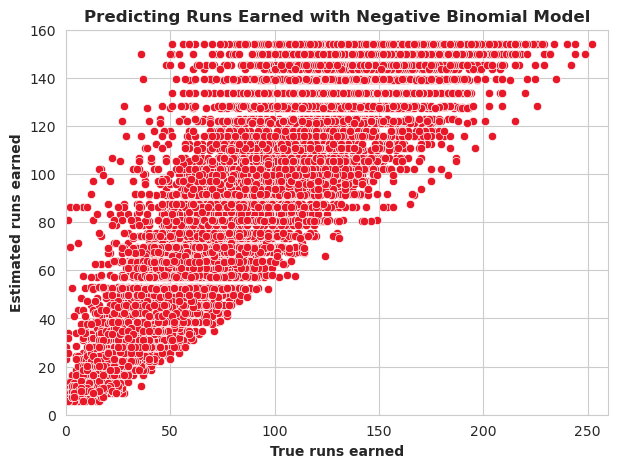

In [180]:
with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.scatterplot(x=y_train_cat.values.ravel(),y=nb_model3.predict(X_train_cat).values,color=red)
    ax.set_xlabel("True runs earned",fontweight="bold")
    ax.set_ylabel("Estimated runs earned",fontweight="bold")
    ax.set_title("Predicting Runs Earned with Negative Binomial Model",fontweight="bold")
    ax.set_xlim(0,260)
    ax.set_ylim(0,160)

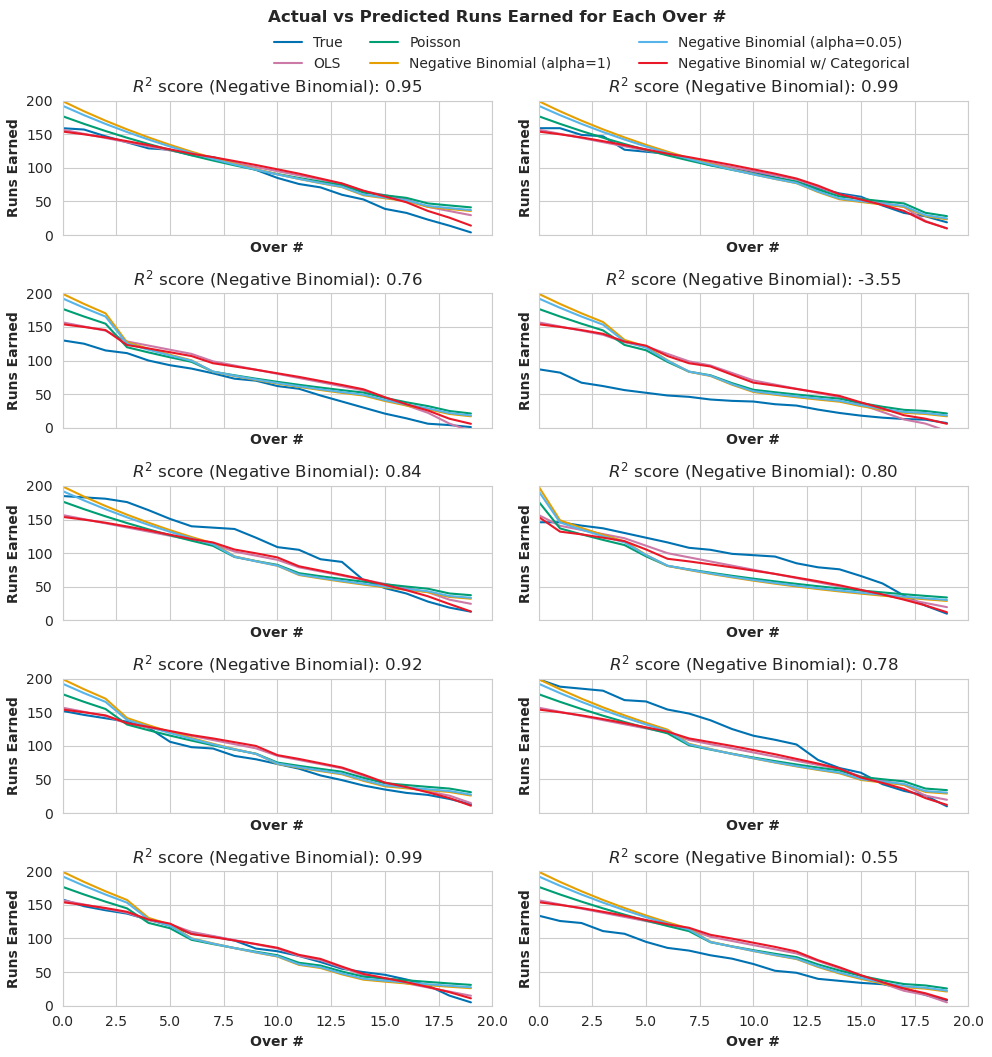

In [179]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(5,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    fig.set_facecolor("w")

    for (id,ax) in zip(test_id,allax.flatten()):
        # For models w/o categorical
        y_test , X_test  = dmatrices(fml, test.loc[test.id==id,:],  return_type='dataframe')
        ax.plot(y_test.values.ravel(),color=blue_cb,label="True")
        ax.plot(ols_model.predict(X_test).values,color=pink,label="OLS")
        ax.plot(poisson_model.predict(X_test).values,color=green,label="Poisson")
        ax.plot(nb_model.predict(X_test).values,color=orange,label="Negative Binomial (alpha=1)")
        ax.plot(nb_model2.predict(X_test).values,color=skyblue,label="Negative Binomial (alpha={:.2f})".format(aux_ols_model.params.item()))

        # For categorical w/o interaction
        local_X_test_cat = X_test_cat.loc[X_test_cat.id==id].drop(columns=["id"])
        cat_predict = nb_model3.predict(local_X_test_cat).values
        ax.plot(cat_predict,color=red,label="Negative Binomial w/ Categorical")
        ax.set_ylabel("Runs Earned",fontweight="bold")
        ax.set_xlabel("Over #",fontweight="bold")
        ax.set_xlim(0,20)
        ax.set_ylim(0,200)
        ax.set_title(r"$R^2$ score (Negative Binomial): " + "{:.2f}".format(r2_score(y_test.values.ravel(),cat_predict)))

    plt.tight_layout()
    allax[0,0].legend(loc="right",bbox_to_anchor=(2,1.35),ncol=3,frameon=False)
    fig.suptitle("Actual vs Predicted Runs Earned for Each Over #",fontweight="bold",y=1.05)
    


### Add interaction terms to categorical

In [198]:
# Using statsmodels and R style formulas
fml3_A = 'runs_earned ~  C(wickets_remaining)*C(overs_remaining) + test_data + id'
# fml3_B = 'runs_earned ~  C(overs_remaining) + wickets_remaining*overs_remaining'

# Design matrices
cols = ["runs_earned","overs_remaining","wickets_remaining"]
y_cat_all2, X_cat_all2 = (dmatrices(fml3_A, 
                                  pd.concat([train,test],axis=0)[['runs_earned', 'overs_remaining', 'wickets_remaining','test_data','id']],
                                  return_type='dataframe'))

# Get train/test dmatrices
X_train_cat2 = X_cat_all2.loc[X_cat_all2.test_data==0,:].drop(columns=["test_data","id"])
y_train_cat2 = y_cat_all2.loc[X_train_cat2.index,:]

X_test_cat2 = X_cat_all.loc[X_cat_all2.test_data==1,:].drop(columns=["test_data"])
y_test_cat2 = y_cat_all.loc[X_test_cat2.index,:]

# GLM with neg binom and custom alpha
nb_model4 = sm.GLM(y_train_cat2, X_train_cat2, family=sm.families.NegativeBinomial(alpha=alpha_val)).fit()
nb_model4.summary()# Add


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            runs_earned   No. Observations:                17751
Model:                            GLM   Df Residuals:                    17645
Model Family:        NegativeBinomial   Df Model:                          105
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -77480.
Date:                Thu, 06 Oct 2022   Deviance:                       19227.
Time:                        10:28:00   Pearson chi2:                 1.75e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.9960
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               1.7716      0.094     18.922      0.000       1.588       1.955
C(wickets_remaining)[T.2]                               0.2952      0.109      2.720      0.007       0.083       0.508
C(wickets_remaining)[T.3]                               0.5311      0.100      5.304      0.000       0.335       0.727
C(wickets_remaining)[T.4]                               0.5385      0.098      5.471      0.000       0.346       0.731
C(wickets_remaining)[T.5]                               0.6456      0.098      6.600      0.000       0.454       0.837
C(wickets_remaining)[T.6]                               0.6890      0.098      7.048      0.000       0.497       0.881
C(wickets_remaining)[T.7]                               0.7552      0.099      7.593      0.000       0.560       0.950
C(wickets_remaining)[T.8]                               0.7454      0.111      6.690      0.000       0.527       0.964
C(wickets_remaining)[T.9]                               1.2875      0.088     14.664      0.000       1.115       1.460
C(wickets_remaining)[T.10]                              1.4632      0.085     17.139      0.000       1.296       1.631
C(overs_remaining)[T.2]                                 0.4807      0.018     26.173      0.000       0.445       0.517
C(overs_remaining)[T.3]                                 0.7751      0.017     45.443      0.000       0.742       0.808
C(overs_remaining)[T.4]                                 0.9773      0.017     57.855      0.000       0.944       1.010
C(overs_remaining)[T.5]                                 1.0926      0.017     63.786      0.000       1.059       1.126
C(overs_remaining)[T.6]                                 1.2242      0.017     72.799      0.000       1.191       1.257
C(overs_remaining)[T.7]                                 1.3057      0.017     76.163      0.000       1.272       1.339
C(overs_remaining)[T.8]                                 1.3481      0.018     75.049      0.000       1.313       1.383
C(overs_remaining)[T.9]                                 1.3946      0.018     76.137      0.000       1.359       1.431
C(overs_remaining)[T.10]                                1.4478      0.018     79.363      0.000       1.412       1.484
C(overs_remaining)[T.11]                                1.4912      0.019     79.374      0.000       1.454       1.528
C(overs_remaining)[T.12]                                1.4999      0.019     77.634      0.000       1.462       1.538
C(overs_remaining)[T.13]                                1.5271      0.020     76.984      0.000       1.488       1.566
C(overs_remaining)[T.14]                                1.5679      0.020     77.28

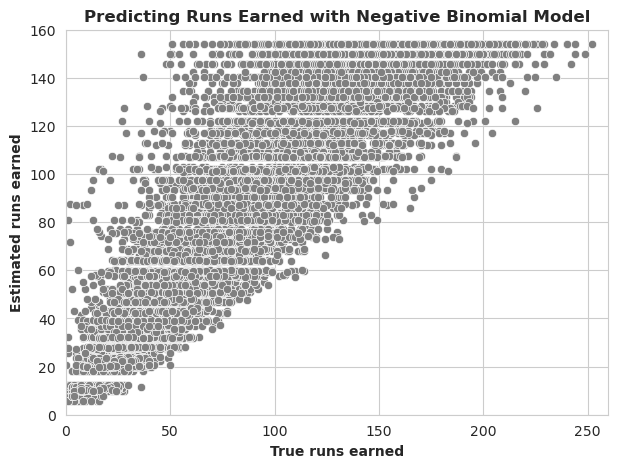

In [199]:
with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.scatterplot(x=y_train_cat2.values.ravel(),y=nb_model4.predict(X_train_cat2).values,color=(0.5,0.5,0.5))
    ax.set_xlabel("True runs earned",fontweight="bold")
    ax.set_ylabel("Estimated runs earned",fontweight="bold")
    ax.set_title("Predicting Runs Earned with Negative Binomial Model",fontweight="bold")
    ax.set_xlim(0,260)
    ax.set_ylim(0,160)

### Markov Chains

Cricket, much like baseball, can be thought of as sequences of discrete events, where at any given state, there is a probability of transitioning to another state. Critically, we consider the process to be memoryless, and thus, the future state only depends on the current state. Using this assumption, we can model the game using Markov chains. We will start by using our data to develop a transition matrix that tells up the probability transitioning from one state to another. 

In [ ]:
# Get each state as tuple
data.loc[:,"overs_wicket_tuple"] = data.loc[:,["overs_remaining","wickets_remaining"]].apply(tuple,axis=1)
data.loc[:,"overs_wicket_tuple_next"] = data.groupby(by="id").overs_wicket_tuple.shift(-1)

# Get size of each group--i.e., number of transitions from a particular state
transition_probability =  (data.groupby(by=["overs_wicket_tuple","overs_wicket_tuple_next"],dropna=False,as_index=False)
                           .agg(instances=pd.NamedAgg(column="runs_earned",aggfunc="size"))
                          )

# Convert to percentage of total in that group                          
transition_probability["probability"] = transition_probability.groupby(by="overs_wicket_tuple").instances.apply(lambda x: x / x.sum())
transition_probability["absorbing"]   = transition_probability.overs_wicket_tuple_next.isna()
transition_probability_copy = transition_probability.copy()

Now we have the probability of transitioning from one state to another (at least those observed in the data). Let's see what that looks like. 

In [ ]:
transition_probability.sample(10)

,overs_wicket_tuple,overs_wicket_tuple_next,instances,probability,absorbing
208,"(8, 10)","(7, 10)",17,0.566667,False
382,"(19, 9)","(18, 8)",16,0.125984,False
28,"(2, 6)","(1, 6)",131,0.612150,False
151,"(6, 7)","(5, 5)",5,0.020833,False
109,"(5, 3)","(4, 1)",1,0.038462,False
128,"(5, 9)","(4, 7)",2,0.032258,False
247,"(10, 9)","(9, 7)",4,0.017857,False
286,"(12, 8)","(11, 8)",215,0.759717,False
328,"(15, 6)","(14, 6)",13,0.764706,False
230,"(9, 10)","(8, 10)",30,0.750000,False


Let's check the initial state:

In [ ]:
transition_probability.groupby(by="overs_wicket_tuple").get_group((20,10))

,overs_wicket_tuple,overs_wicket_tuple_next,instances,probability,absorbing
388,"(20, 10)","(19, 8)",16,0.017354,False
389,"(20, 10)","(19, 9)",127,0.137744,False
390,"(20, 10)","(19, 10)",779,0.844902,False


This tells us that within the data, we only go three directions:

\begin{align*}
\text{Complete one over, retain all wickets} &: \mathbb{P} ((20,10) \rightarrow (19,10)) = 84\%\\
\text{Complete one over, lose one wicket} &: \mathbb{P} ((20,10) \rightarrow (19,9)) = 13\%\\
\text{Complete one over, lose two wickets} &: \mathbb{P} ((20,10) \rightarrow (19,8)) = 2\%\\
\end{align*}

This can be nicely shown using directed graphs, but for the sake of time this is not shown here. 

#### Simulate Innings

Now we will write a function to simulate a single innings based on the initial state and the transition probabilities. 

In [ ]:
# Simulate one innings using our markov chain model
def simulate_innings(transition_probability,initial_state=(20,10),n=1):
    # Get transition probabilites grouped by state
    tp = transition_probability.groupby(by="overs_wicket_tuple")
    # Initialize experiment
    experiment = []
    # initialize counter
    cnt = 0
    while cnt < n:
        # If absorbing state end curent loop
        absorbing_state = 0
        # Initialize for this trial
        trial = []
        # Initialize state
        current_state=(20,10)#initial_state
        trial.append(current_state)
        while not absorbing_state:
            # Get group for that state
            local = tp.get_group(current_state)
            # Get random choice based on probabilities
            idx = np.random.choice(local.index.values,p=local.probability)
            next_state = local.loc[idx,"overs_wicket_tuple_next"]
            # Check if absorbing state else get state
            if ~local.loc[idx,"absorbing"]:
                next_state = local.loc[idx,"overs_wicket_tuple_next"]
                trial.append(next_state)
                current_state = next_state
            else: # break loop
                if len(trial) < 20:
                    trial.extend((20-len(trial))*[np.nan])
                experiment.append(trial)
                cnt += 1
                absorbing_state=1

    return experiment #if n > 1 else experiment[0]

simulation = simulate_innings(transition_probability,initial_state=(20,10),n=100)
print("A single simulated innings looks like this: ",simulation[0])


A single simulated innings looks like this:  [(20, 10), (19, 10), (18, 10), (17, 10), (16, 10), (15, 10), (14, 10), (13, 10), (12, 8), (11, 8), (10, 8), (9, 8), (8, 8), (7, 8), (6, 8), (5, 8), (4, 7), (3, 7), (2, 7), (1, 6)]


Let's see what that looks like in our 2D heatmap.

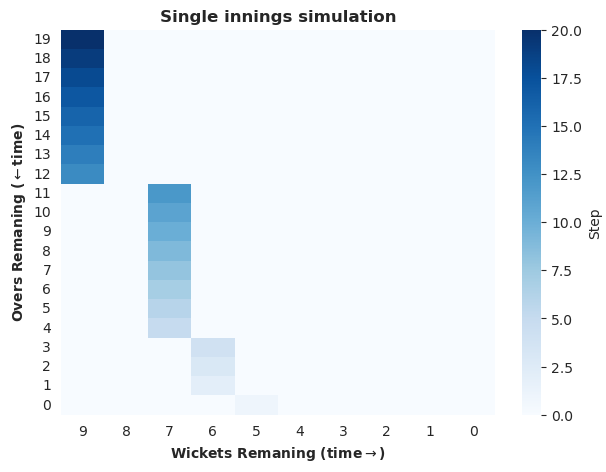

In [ ]:
def map_path(innings):
    transitions = np.zeros((20,10))
    for game_step in innings:
        if not pd.isna(game_step):
            i, j = game_step
            transitions[20-i,10-j] += 1
    return transitions

single_innings = map_path(simulation[0])

with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # Heatmap
    temp = np.arange(1,21)
    ax = sns.heatmap(ax=ax,data=temp[:,np.newaxis]*np.flipud(np.fliplr(single_innings)),
                        cmap="Blues",cbar_kws={"label":"Step"})
    ax = format_heatmap(ax,"Single innings simulation")
    

Let's see what that looks like for many innings and we can compare that to our observed data.

In [ ]:
# Simulate lots of innings
n_games = 1000#100_000
simulation = simulate_innings(transition_probability,initial_state=(20,10),n=n_games)

# Add all innings together
out = np.zeros((20,10))
for step in simulation:
    out += map_path(step)

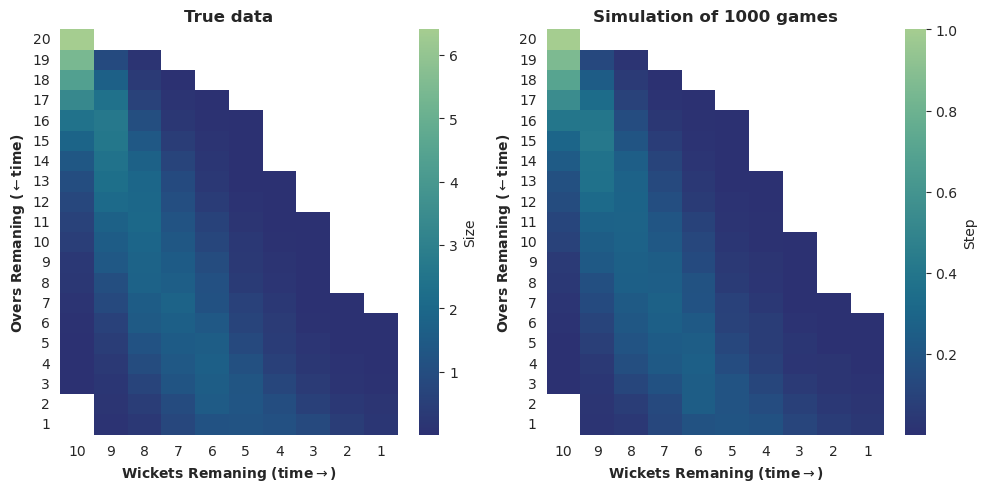

In [ ]:
with sns.axes_style("whitegrid"):
    
    # Make figure
    fig, ax = plt.subplots(1,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(10,5)
    
    # Get size of each group
    groupsizes = data.groupby(by=["overs_remaining","wickets_remaining"],as_index=False).agg(runs_earned_size=pd.NamedAgg(column="runs_earned",aggfunc="size"))
    # Heatmap
    temp = groupsizes.pivot("overs_remaining","wickets_remaining","runs_earned_size")
    ax[0] = sns.heatmap(ax=ax[0],data=temp/len(data.groupby(by=["overs_remaining","wickets_remaining"])),
                        cmap="crest_r",cbar_kws={"label":"Size"})
    ax[0] = format_heatmap(ax[0],"True data")

    # Heatmap
    hmapdata = np.flipud(np.fliplr(out/n_games))
    hmapdata[hmapdata==0] = np.nan
    ax[1] = sns.heatmap(ax=ax[1],data=hmapdata,
                        cmap="crest_r",cbar_kws={"label":"Step"})
    ax[1] = format_heatmap(ax[1],"Simulation of {} games".format(n_games))
    ax[1].set_yticklabels(list(map(str,np.arange(1,21))))
    ax[1].set_xticklabels(list(map(str,np.arange(1,11))))
    plt.tight_layout()

#### Get Expected Runs For Each Simulated Innings

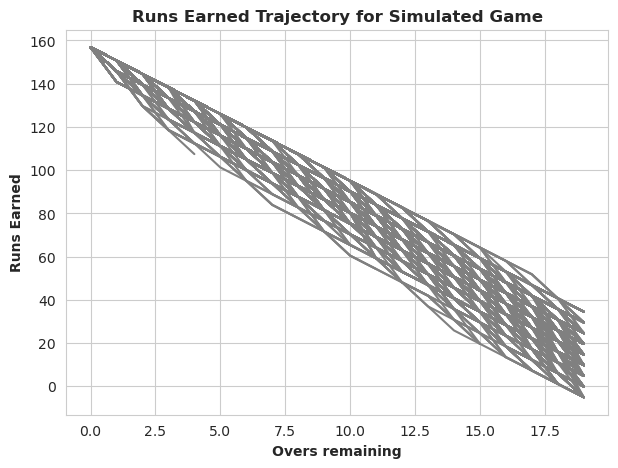

In [ ]:
def predict_runs_earned(game,model):
    # Remove nans
    game2 = [x for x in game if not pd.isna(x)]
    # Make arrays and add constant
    test_data = sm.add_constant(pd.DataFrame(game2).to_numpy())
    return model.predict(test_data) # predict and return

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    for game in simulation:
        predicted = predict_runs_earned(game,ols_model)
        ax.plot(range(0,len(predicted)),predicted,color=grey)

    ax.set_xlabel("Overs remaining",fontweight="bold")
    ax.set_ylabel("Runs Earned",fontweight="bold")
    # ax.set_xticklabels(list(map(str,np.arange(1,11))))
    ax.set_title("Runs Earned Trajectory for Simulated Game",fontweight="bold")

Very interesting. Out of curiosity, let's just add a little noise to the prediction.

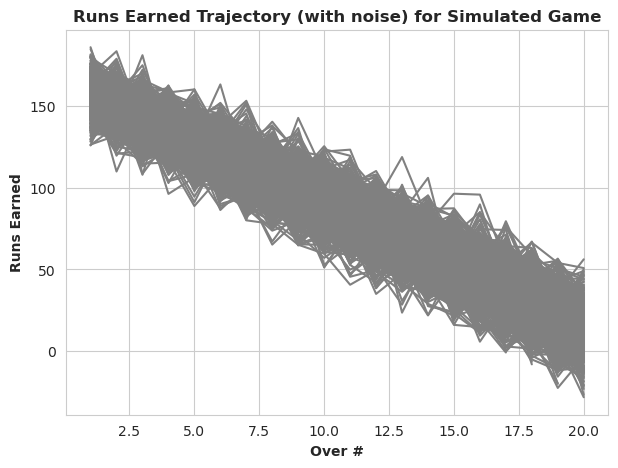

In [ ]:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    for game in simulation:
        predicted = predict_runs_earned(game,ols_model)
        ax.plot(range(1,len(predicted)+1),predicted + np.random.normal(0,10,size=len(predicted)),color=grey)

    ax.set_xlabel("Over #",fontweight="bold")
    ax.set_ylabel("Runs Earned",fontweight="bold")
    # ax.set_xticklabels(list(map(str,np.arange(1,21))))
    ax.set_title("Runs Earned Trajectory (with noise) for Simulated Game",fontweight="bold")

So we definitely added noise for sure. It may be a bit too much noise in some parts and not enough in others. For example, we could do a better job if we estimated the variance in each game state and added noise with respect to each one. Nonetheless, we now have a Markov Chain model that allows us to simulate games and a prediction model to estimate the earned runs given the game state. 

One thing we could do is consider what happens right after the start of the inning to see which way the game trajectories play out. It is possible that game states towards the middle of the innings are in fact more important, but for the sake of this analysis, we will ask what happens if you start transition from one over to the next with and without losing a wicket. In other words, we assume, on average, that this is a proxy for more aggressive or more conservative batting, respectively. 

In [ ]:
# Simulate lots of innings
n_games = 1000#100_000
simCon = simulate_innings(transition_probability,initial_state=(19,10),n=n_games)
simAgg = simulate_innings(transition_probability,initial_state=(19,9),n=n_games)

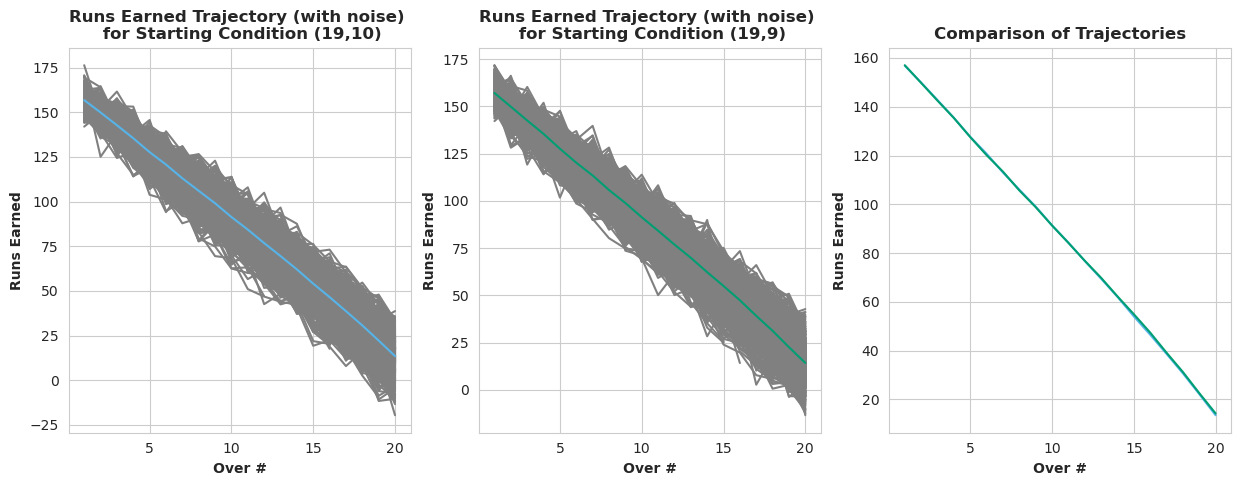

In [ ]:
with sns.axes_style("whitegrid"):
    
    # Make figure
    fig, ax = plt.subplots(1,3)#,sharey=True)#sharex=True)
    fig.set_size_inches(15,5)

    # Conservative play
    con_score = []
    con_all = []
    for game in simCon:
        predicted_con = predict_runs_earned(game,ols_model) 
        if len(predicted_con) < 20:
            predicted_con = np.append(predicted_con,np.ones(20 - len(predicted_con),)+np.nan)
        predicted_con += np.random.normal(0,5,size=len(predicted_con))
        con_all.append(predicted_con)
        ax[0].plot(range(1,len(predicted_con)+1),predicted_con,color=grey)

    ax[0].plot(range(1,20+1),np.nanmean(np.array(con_all),axis=0),color=skyblue)
    ax[0].set_xlabel("Over #",fontweight="bold")
    ax[0].set_ylabel("Runs Earned",fontweight="bold")
    # ax.set_xticklabels(list(map(str,np.arange(1,21))))
    ax[0].set_title("Runs Earned Trajectory (with noise) \n for Starting Condition (19,10)",fontweight="bold")


    # Aggressive play
    agg_score = []
    agg_all = []
    for game in simAgg:
        predicted_agg = predict_runs_earned(game,ols_model)
        if len(predicted_agg) < 20:
            predicted_agg = np.append(predicted_agg,np.ones(20 - len(predicted_agg),)+np.nan)
        predicted_agg += np.random.normal(0,5,size=len(predicted_agg))
        agg_all.append(predicted_agg)
        ax[1].plot(range(1,len(predicted_agg)+1),predicted_agg,color=grey)

    ax[1].plot(range(1,20+1),np.nanmean(np.array(agg_all),axis=0),color=green)
    ax[1].set_xlabel("Over #",fontweight="bold")
    ax[1].set_ylabel("Runs Earned",fontweight="bold")
    # ax.set_xticklabels(list(map(str,np.arange(1,21))))
    ax[1].set_title("Runs Earned Trajectory (with noise) \n for Starting Condition (19,9)",fontweight="bold")


    # Plot them together
    ax[2].plot(range(1,20+1),np.nanmean(np.array(con_all),axis=0),color=skyblue)
    ax[2].plot(range(1,20+1),np.nanmean(np.array(agg_all),axis=0),color=green)
    ax[2].set_xlabel("Over #",fontweight="bold")
    ax[2].set_ylabel("Runs Earned",fontweight="bold")
    # ax.set_xticklabels(list(map(str,np.arange(1,21))))
    ax[2].set_title("Comparison of Trajectories",fontweight="bold")

We could compute the area under the curve to determine which has overall higher predicted runs earned...

In [ ]:
print("Conservative Batting: {:.2f} \n   Agressive Batting: {:.2f}".format(np.trapz(np.nanmean(np.array(con_all),axis=0)),np.trapz(np.nanmean(np.array(agg_all),axis=0))))

Conservative Batting: 1655.98 
   Agressive Batting: 1658.72


Well, from these results, it is quite difficult to determine which is better. If I use the numerical integration results for this simulation (and squint a little), I would have to say that it is *slightly* better to be conservative and protect your wickets early on than to bat agressively and risk losing one. However, it is possible that with different simulations we get slightly different results. 

## Future Work and Final Thoughts

The approach outlined here was to model the relationship between the current state--overs and wickets remaining--and the outcome--runs earned. We used linear models, including ordinary least squares, Poisson regression, and Negative Binomial regression. It also made sense to try converting the predictors to categorical variables. In addition, we modeled the innings as Markov chains, where we developed a state transition matrix from our data and simulated innings to estimate the variability in potential outcomes. While this is interesting, there is certainly room for improvment.

- Improve the linear models to better capture the spread of the data, particularly in places where the runs earned are signficantly over estimated. This can be done by dealing with the heteroskedacity in the data.
- We could consider applying more advanced machine learning methods to make better predictions, but we risk losing interpretability at the cost of better prediction. For this particular project, I decided that intepretable statistical models were a better choice, but we certainly implement models ranging from support vector machines to random forests to deep learning models. 
- Model each team independently to identify differences in game play. For example, each team might prove to have signficantly different weights for the predictors, where unit changes in wickets result in higher runs earned for some teams and unit changes in overs results in higher runs earned for others. This could be done using a heirarchical Bayesian model.
- Improve the Markov chain model to introduce more variability within the model. For example, in this case, we only modeled states that happened in the data. However, it is possible that other game states could be achieved, albeit with much lower probabilties than those in the data. To do this, we would not only need to assign each missing state a probability of existing within the dataset, but we also need to fabricate transition probabilities for each of the adjacent states within the transition matrix. 
- Another way to improve the Markov model is to use a technique used in Reinforcement Learning and Markov Decision Process, such as an epsilon greedy algorithm, to add noise. In this case, we could sample the state space, but we could add noise to the estimate but perturbing the transition probabilities or simply choosing one that was not selected from the sampling. We could randomly decide to treat them as uniformly distributed, or simply choose to take the one with lowest probability, just to be a contrarian, of course!
- In our final figure, we average out the individual effects of different trajectories. For example, if we plot the earned run curves for each team, we may find that we can cluster them into distint groups, where some have higher resulting earned run curves than others.